<a href="https://colab.research.google.com/github/San-lab-ship/pozos-petroleros/blob/main/pozospetroleros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

df_pozos generado (primeras 5 filas con ubicación):
    pozo_id tipo_yacimiento  profundidad_md  diametro_pul  \
0  POZO_001        Arenisca         7232.11           6.3   
1  POZO_002       Carbonato        10399.30           4.9   
2  POZO_003        Arenisca         9181.80           6.0   
3  POZO_004        Esquisto         5130.46           4.6   
4  POZO_005        Arenisca         5068.49           5.5   

  fecha_inicio_produccion  reserva_estimada_bbl  \
0              2019-10-17               1433912   
1              2018-01-12               3708533   
2              2018-07-02               1834774   
3              2019-12-19                585629   
4              2018-06-26               2637129   

            metodo_levantamiento              cuenca_sedimentaria  \
0                  Flujo Natural                Llanos Orientales   
1  Bomba Electrosumergible (BES)                Llanos Orientales   
2           Bombeo Mecánico (BM)                         Putumayo  

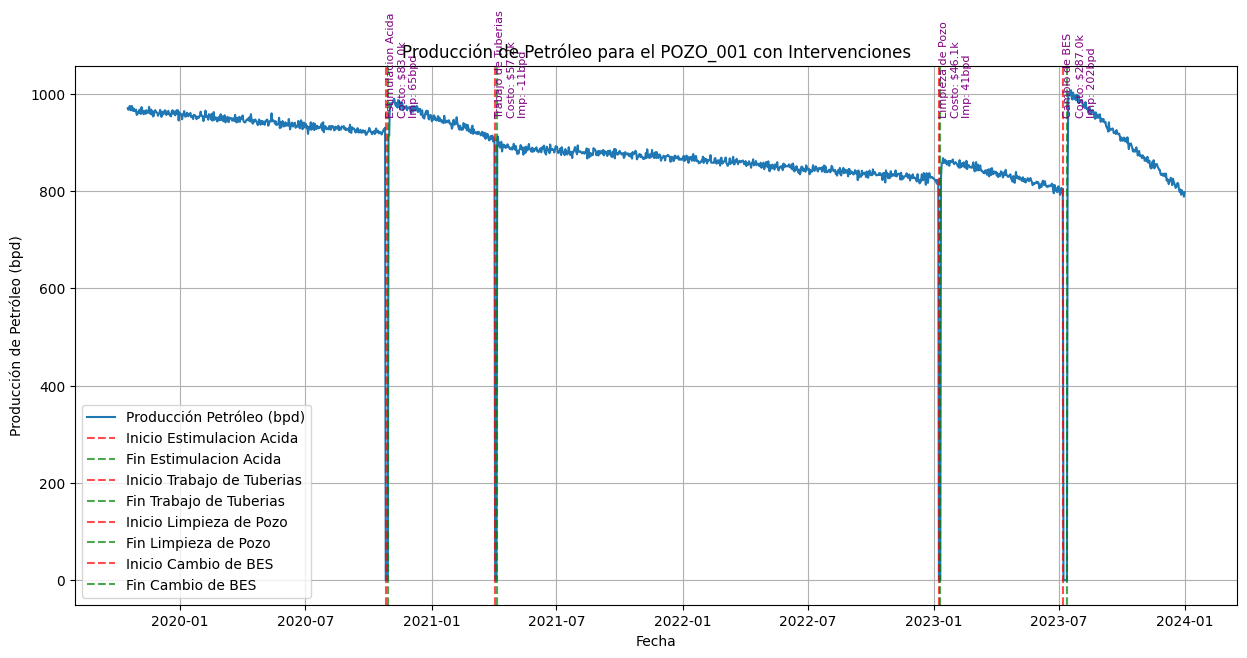

In [57]:
# Generación de datos Pozos Petroleros

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

np.random.seed(42)
random.seed(42)

NUM_POZOS = 15
FECHA_INICIO_SIMULACION = datetime(2018, 1, 1)
FECHA_FIN_SIMULACION = datetime(2023, 12, 31)
DURACION_IMPACTO_INTERVENCION_DIAS = 180


TIPOS_YACIMIENTO = ['Arenisca', 'Carbonato', 'Esquisto']
METODOS_LEVANTAMIENTO = ['Flujo Natural', 'Bomba Electrosumergible (BES)', 'Bombeo Mecánico (BM)', 'Gas Lift']


UBICACIONES_COLOMBIA = {
    'Llanos Orientales': ['Meta', 'Casanare', 'Arauca'],
    'Valle Medio del Magdalena (VMM)': ['Santander', 'Boyacá', 'Cundinamarca'],
    'Valle Inferior del Magdalena (VIM)': ['Bolívar', 'Cesar', 'Magdalena'],
    'Putumayo': ['Putumayo'],
    'Catatumbo': ['Norte de Santander']
}
CAMPOS_FICTICIOS_POR_CUENCA = {
    'Llanos Orientales': ['Campo Rubiales', 'Campo Castilla', 'Campo Quifa', 'Campo Apiay'],
    'Valle Medio del Magdalena (VMM)': ['Campo La Cira-Infantas', 'Campo Yariguí', 'Campo Velásquez'],
    'Valle Inferior del Magdalena (VIM)': ['Campo Chuchupa', 'Campo Ballena', 'Campo La Guajira'],
    'Putumayo': ['Campo Orito', 'Campo Suroriente'],
    'Catatumbo': ['Campo Tibú', 'Campo Sardinata']}



COSTOS_INTERVENCION_BASE = [
    {'tipo_intervencion': 'Estimulacion Acida', 'costo_promedio_usd': 80000, 'duracion_promedio_dias': 3, 'impacto_produccion_promedio_bpd': 50},
    {'tipo_intervencion': 'Cambio de BES', 'costo_promedio_usd': 250000, 'duracion_promedio_dias': 7, 'impacto_produccion_promedio_bpd': 150},
    {'tipo_intervencion': 'Limpieza de Pozo', 'costo_promedio_usd': 40000, 'duracion_promedio_dias': 2, 'impacto_produccion_promedio_bpd': 30},
    {'tipo_intervencion': 'Fracturamiento Hidraulico', 'costo_promedio_usd': 700000, 'duracion_promedio_dias': 10, 'impacto_produccion_promedio_bpd': 300},
    {'tipo_intervencion': 'Recompletacion', 'costo_promedio_usd': 500000, 'duracion_promedio_dias': 15, 'impacto_produccion_promedio_bpd': 200},
    {'tipo_intervencion': 'Trabajo de Tuberias', 'costo_promedio_usd': 60000, 'duracion_promedio_dias': 4, 'impacto_produccion_promedio_bpd': 40},
]
df_costos_intervencion_base = pd.DataFrame(COSTOS_INTERVENCION_BASE)


def generar_pozo_info(i):
    """Genera la información estática para un pozo, incluyendo ubicación en Colombia."""
    pozo_id = f'POZO_{i+1:03d}'
    fecha_inicio_prod = FECHA_INICIO_SIMULACION + timedelta(days=random.randint(0, 365*2))
    reserva_estimada = random.randint(500_000, 5_000_000)

    cuenca_elegida = random.choice(list(UBICACIONES_COLOMBIA.keys()))
    departamento_elegido = random.choice(UBICACIONES_COLOMBIA[cuenca_elegida])
    campo_elegido = random.choice(CAMPOS_FICTICIOS_POR_CUENCA[cuenca_elegida])

    return {
        'pozo_id': pozo_id,
        'tipo_yacimiento': random.choice(TIPOS_YACIMIENTO),
        'profundidad_md': round(random.uniform(5000, 15000), 2),
        'diametro_pul': round(random.uniform(4.5, 7.0), 1),
        'fecha_inicio_produccion': fecha_inicio_prod,
        'reserva_estimada_bbl': reserva_estimada,
        'metodo_levantamiento': random.choice(METODOS_LEVANTAMIENTO),
        'cuenca_sedimentaria': cuenca_elegida,
        'departamento': departamento_elegido,
        'campo_petrolero': campo_elegido
    }

def calcular_produccion_base_arps(q_initial, d_initial, b_factor, days_since_start):
    """Calcula la producción base usando el modelo de declive de Arps."""
    if b_factor == 0:
        return q_initial * np.exp(-d_initial * days_since_start)
    else:
        return q_initial / ((1 + b_factor * d_initial * days_since_start)**(1/b_factor))

def generar_intervencion_data(pozo_id, intervencion_counter, fecha_intervencion_inicio):
    """Genera datos para una intervención específica."""
    intervencion_base = df_costos_intervencion_base.sample(1).iloc[0]

    tipo_int = intervencion_base['tipo_intervencion']
    costo_base = intervencion_base['costo_promedio_usd']
    duracion_base = intervencion_base['duracion_promedio_dias']
    impacto_base = intervencion_base['impacto_produccion_promedio_bpd']

    costo = round(costo_base * random.uniform(0.8, 1.2), 2)
    duracion = random.randint(max(1, int(duracion_base * 0.7)), int(duracion_base * 1.3))
    impacto = round(impacto_base * random.uniform(0.5, 1.5) if random.random() < 0.8 else impacto_base * random.uniform(-0.5, 0.2), 2)

    fecha_fin_int = fecha_intervencion_inicio + timedelta(days=duracion)

    return {
        'intervencion_id': f'INT_{intervencion_counter:05d}',
        'pozo_id': pozo_id,
        'fecha_inicio': fecha_intervencion_inicio,
        'fecha_fin': fecha_fin_int,
        'tipo_intervencion': tipo_int,
        'costo_usd': costo,
        'duracion_dias': duracion,
        'impacto_produccion_bpd_post': impacto}



def generar_datos_pozos_y_produccion():
    """Genera los DataFrames de pozos, producción e intervenciones."""
    all_pozos_data = []
    all_production_data = []
    all_intervencion_data = []
    intervencion_counter = 0

    for i in range(NUM_POZOS):
        pozo_info = generar_pozo_info(i)
        all_pozos_data.append(pozo_info)

        pozo_id = pozo_info['pozo_id']
        fecha_inicio_prod = pozo_info['fecha_inicio_produccion']

        q_initial = random.uniform(200, 1500)
        b_factor = random.uniform(0.3, 0.7) if pozo_info['tipo_yacimiento'] == 'Esquisto' else random.uniform(0.0, 0.5)
        d_initial = random.uniform(0.0005, 0.001) if pozo_info['tipo_yacimiento'] == 'Esquisto' else random.uniform(0.0001, 0.0005)

        current_date = fecha_inicio_prod
        while current_date <= FECHA_FIN_SIMULACION:
            days_since_start = (current_date - fecha_inicio_prod).days
            q_base = calcular_produccion_base_arps(q_initial, d_initial, b_factor, days_since_start)
            production_noise = np.random.normal(0, 5)
            final_production_value = max(0, q_base + production_noise)

            all_production_data.append({
                'pozo_id': pozo_id,
                'fecha': current_date,
                'produccion_petroleo_bpd': round(final_production_value, 2),
                'produccion_agua_bpd': round(final_production_value * random.uniform(0.1, 0.8), 2),
                'presion_fondo_psi': round(random.uniform(1000, 3000) * (final_production_value / q_initial)**0.1 if final_production_value > 0 else 0, 2),
                'temperatura_fondo_f': round(random.uniform(150, 250), 2),
                'estado_operacional': 'Produciendo'
            })
            current_date += timedelta(days=1)

        num_intervenciones = random.randint(1, 5)
        fechas_posibles_intervencion = pd.date_range(
            fecha_inicio_prod + timedelta(days=180),
            FECHA_FIN_SIMULACION - timedelta(days=30),
            freq='D'
        ).tolist()

        if len(fechas_posibles_intervencion) >= num_intervenciones:
            fechas_intervenciones_programadas = random.sample(fechas_posibles_intervencion, num_intervenciones)
            fechas_intervenciones_programadas.sort()

            for f_intervencion in fechas_intervenciones_programadas:
                intervencion_counter += 1
                interv_data = generar_intervencion_data(pozo_id, intervencion_counter, f_intervencion)
                all_intervencion_data.append(interv_data)

    df_pozos = pd.DataFrame(all_pozos_data)
    df_produccion = pd.DataFrame(all_production_data)
    df_intervenciones = pd.DataFrame(all_intervencion_data)

    df_produccion['fecha'] = pd.to_datetime(df_produccion['fecha'])
    df_intervenciones['fecha_inicio'] = pd.to_datetime(df_intervenciones['fecha_inicio'])
    df_intervenciones['fecha_fin'] = pd.to_datetime(df_intervenciones['fecha_fin'])
    df_pozos['fecha_inicio_produccion'] = pd.to_datetime(df_pozos['fecha_inicio_produccion'])

    return df_pozos, df_produccion, df_intervenciones

def aplicar_impacto_e_inactividad(df_produccion_raw, df_intervenciones):
    """Aplica los estados de inactividad por intervención y el impacto post-intervención."""
    temp_production_list = []

    for pozo_id, group in df_produccion_raw.groupby('pozo_id'):
        pozo_prod_df = group.copy().sort_values('fecha')
        pozo_interv_df = df_intervenciones[df_intervenciones['pozo_id'] == pozo_id].sort_values('fecha_inicio')

        for _, interv in pozo_interv_df.iterrows():
            mask_shut_in = (pozo_prod_df['fecha'] >= interv['fecha_inicio']) & \
                           (pozo_prod_df['fecha'] <= interv['fecha_fin'])
            pozo_prod_df.loc[mask_shut_in, 'estado_operacional'] = 'Intervencion'
            pozo_prod_df.loc[mask_shut_in, 'produccion_petroleo_bpd'] = 0
            pozo_prod_df.loc[mask_shut_in, 'produccion_agua_bpd'] = 0
            pozo_prod_df.loc[mask_shut_in, 'presion_fondo_psi'] = 0
            pozo_prod_df.loc[mask_shut_in, 'temperatura_fondo_f'] = 0

            fecha_inicio_impacto = interv['fecha_fin'] + timedelta(days=random.randint(1, 3))

            for day_offset in range(1, DURACION_IMPACTO_INTERVENCION_DIAS + 1):
                current_impact_date = fecha_inicio_impacto + timedelta(days=day_offset)
                if current_impact_date > FECHA_FIN_SIMULACION:
                    break

                idx_prod = pozo_prod_df[pozo_prod_df['fecha'] == current_impact_date].index
                if not idx_prod.empty:
                    current_idx = idx_prod[0]
                    decay_factor = max(0, 1 - (day_offset / DURACION_IMPACTO_INTERVENCION_DIAS))
                    impacto_actual = interv['impacto_produccion_bpd_post'] * decay_factor
                    pozo_prod_df.loc[current_idx, 'produccion_petroleo_bpd'] = max(0, pozo_prod_df.loc[current_idx, 'produccion_petroleo_bpd'] + impacto_actual)

        temp_production_list.append(pozo_prod_df)

    df_produccion_final = pd.concat(temp_production_list).sort_values(['pozo_id', 'fecha']).reset_index(drop=True)
    return df_produccion_final


df_pozos, df_produccion_raw, df_intervenciones = generar_datos_pozos_y_produccion()
df_produccion_final = aplicar_impacto_e_inactividad(df_produccion_raw, df_intervenciones)


print("df_pozos generado (primeras 5 filas con ubicación):")
print(df_pozos.head())
print("\n")

print("df_costos_intervencion_base generado:")
print(df_costos_intervencion_base)
print("\n")

print("df_produccion_final generado (primeras 5 filas):")
print(df_produccion_final.head())
print("\n")

print("df_intervenciones generado (primeras 5 filas):")
print(df_intervenciones.head())
print("\n")

print(f"Número total de registros de producción: {len(df_produccion_final)}")
print(f"Número total de intervenciones: {len(df_intervenciones)}")

pozo_ejemplo = 'POZO_001'
df_ejemplo_prod = df_produccion_final[df_produccion_final['pozo_id'] == pozo_ejemplo]
df_ejemplo_interv = df_intervenciones[df_intervenciones['pozo_id'] == pozo_ejemplo]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(df_ejemplo_prod['fecha'], df_ejemplo_prod['produccion_petroleo_bpd'], label='Producción Petróleo (bpd)')

for _, interv in df_ejemplo_interv.iterrows():
    plt.axvline(interv['fecha_inicio'], color='r', linestyle='--', alpha=0.7, label=f"Inicio {interv['tipo_intervencion']}")
    plt.axvline(interv['fecha_fin'], color='g', linestyle='--', alpha=0.7, label=f"Fin {interv['tipo_intervencion']}")
    plt.text(interv['fecha_inicio'], plt.ylim()[1]*0.9, f"{interv['tipo_intervencion']}\nCosto: ${interv['costo_usd']/1000:.1f}k\nImp: {interv['impacto_produccion_bpd_post']:.0f}bpd",
             rotation=90, va='bottom', ha='left', fontsize=8, color='purple')

plt.title(f'Producción de Petróleo para el {pozo_ejemplo} con Intervenciones')
plt.xlabel('Fecha')
plt.ylabel('Producción de Petróleo (bpd)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Generación de datos Pozos Petroleros

Los resultados de la generación de datos sintéticos, incluyendo la información de ubicación geográfica en Colombia, son óptimos para la fase actual de este proyecto, que es la construcción de un prototipo de modelo. Han logrado generar un conjunto de datos que simula de manera convincente el comportamiento de pozos petroleros en el contexto colombiano, incorporando variaciones geográficas y operativas.

El df_pozos ahora incluye con éxito cuenca_sedimentaria, departamento y campo_petrolero con valores realistas para Colombia (ej., "Llanos Orientales", "Arauca", "Campo Quifa"). Esta adición es crucial porque sienta las bases para futuros análisis más sofisticados que podrían considerar el impacto de factores geográficos en la producción y el éxito de las intervenciones. Por ejemplo, podríamos observar que ciertas intervenciones son más efectivas en la cuenca de los Llanos que en el Putumayo, o que los pozos en Arenisca en Santander se comportan de manera diferente a los de Carbonato en Casanare.

La gráfica de producción para el POZO_001 continúa demostrando el patrón esperado de declive natural, con pausas de producción (shut-in) durante las intervenciones y subsecuentes impactos. Es particularmente interesante notar la variabilidad en los impactos, donde la segunda intervención (Trabajo de Tuberias) tuvo un impacto ligeramente negativo, y las subsiguientes (Limpieza de Pozo, Cambio de BES) generaron incrementos positivos. Esto refleja la realidad de las operaciones petroleras, donde no todas las intervenciones son igualmente exitosas. La cantidad de registros de producción y de intervenciones generadas es más que suficiente para comenzar con el análisis exploratorio de datos y la ingeniería de características.

En conclusión, este conjunto de datos sintético con sus ubicaciones hipotéticas en cuencas como los Llanos Orientales y el Valle Medio del Magdalena, y sus campos asociados, proporciona una base excelente para avanzar en la construcción de un modelo de predicción y optimización de intervenciones que sea relevante para el sector de hidrocarburos en Colombia.

df_pozos generado (primeras 5 filas con ubicación):
    pozo_id tipo_yacimiento  profundidad_md  diametro_pul  \
0  POZO_001        Arenisca         7232.11           6.3   
1  POZO_002       Carbonato        10399.30           4.9   
2  POZO_003        Arenisca         9181.80           6.0   
3  POZO_004        Esquisto         5130.46           4.6   
4  POZO_005        Arenisca         5068.49           5.5   

  fecha_inicio_produccion  reserva_estimada_bbl  \
0              2019-10-17               1433912   
1              2018-01-12               3708533   
2              2018-07-02               1834774   
3              2019-12-19                585629   
4              2018-06-26               2637129   

            metodo_levantamiento              cuenca_sedimentaria  \
0                  Flujo Natural                Llanos Orientales   
1  Bomba Electrosumergible (BES)                Llanos Orientales   
2           Bombeo Mecánico (BM)                         Putumayo  

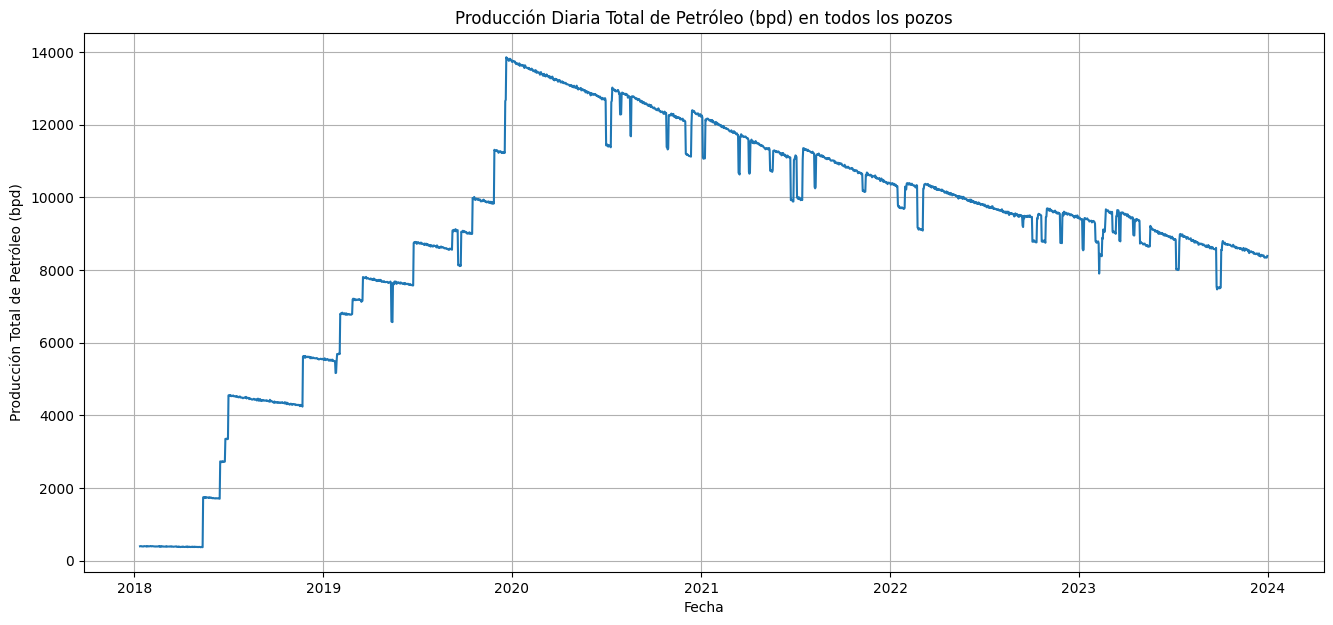

/tmp/ipython-input-4-4095526534.py:282: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_produccion_yacimiento_mensual = df_produccion_yacimiento.set_index('fecha').groupby([pd.Grouper(freq='M'), 'tipo_yacimiento'])['produccion_petroleo_bpd'].mean().reset_index()


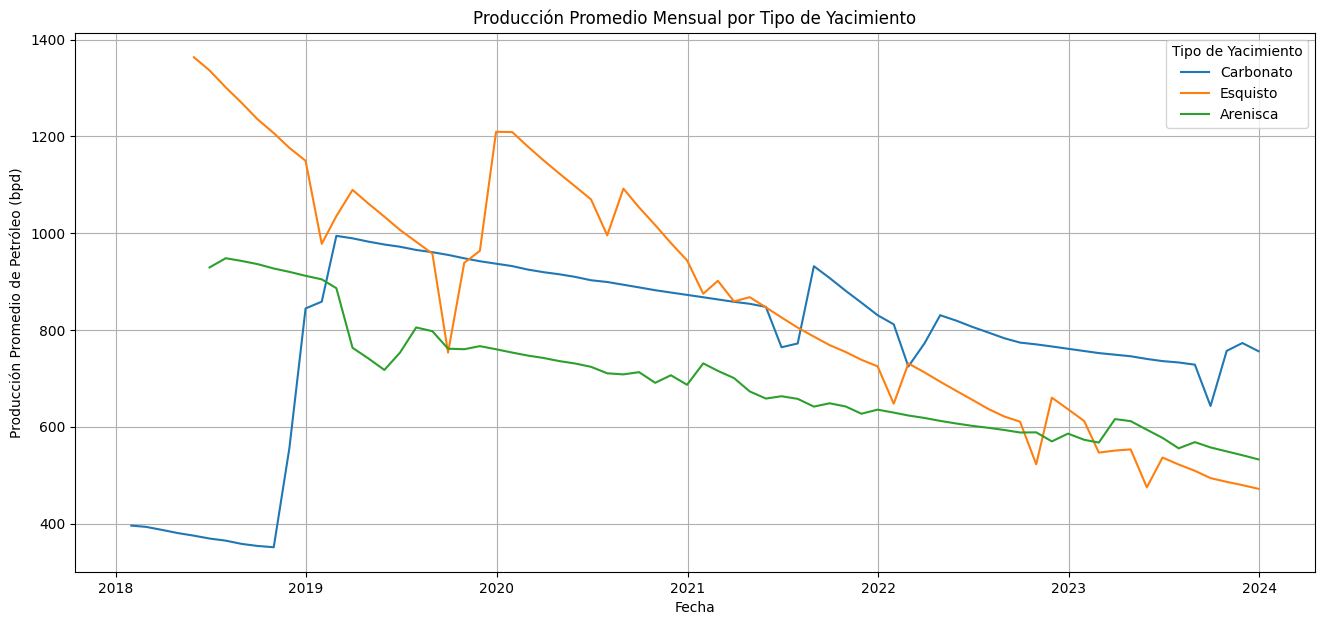

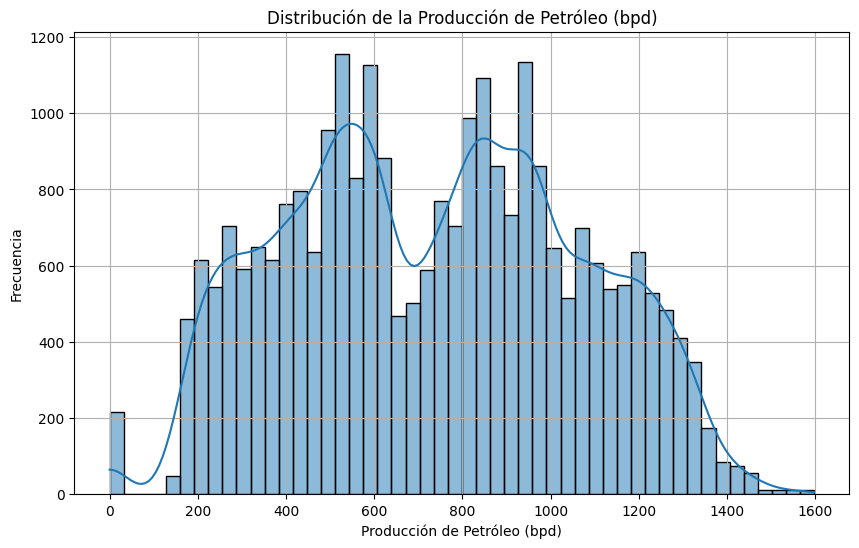

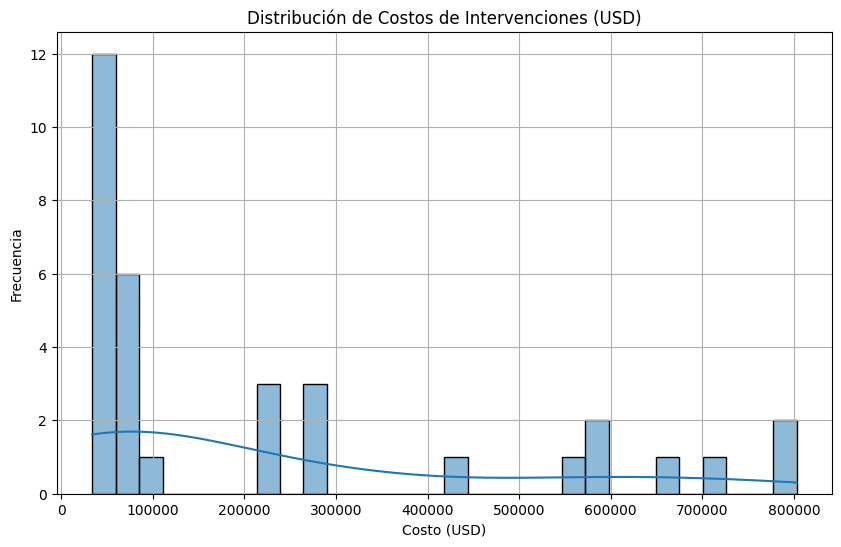

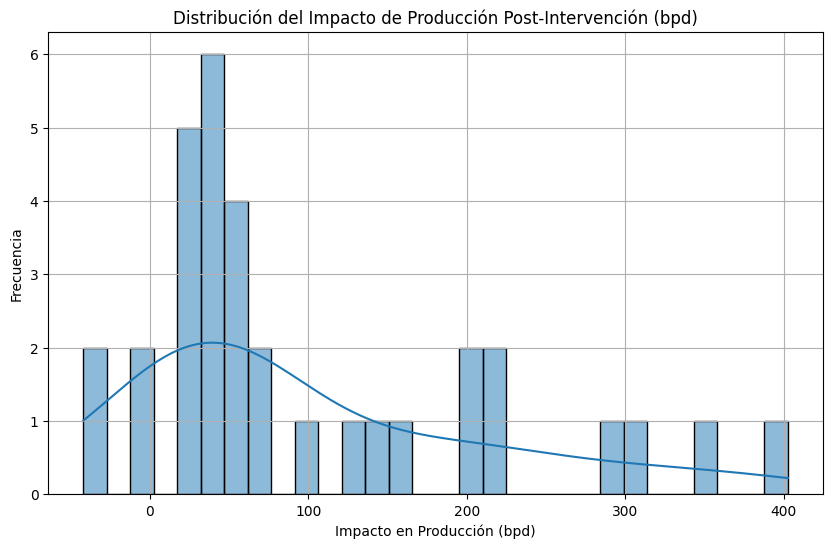

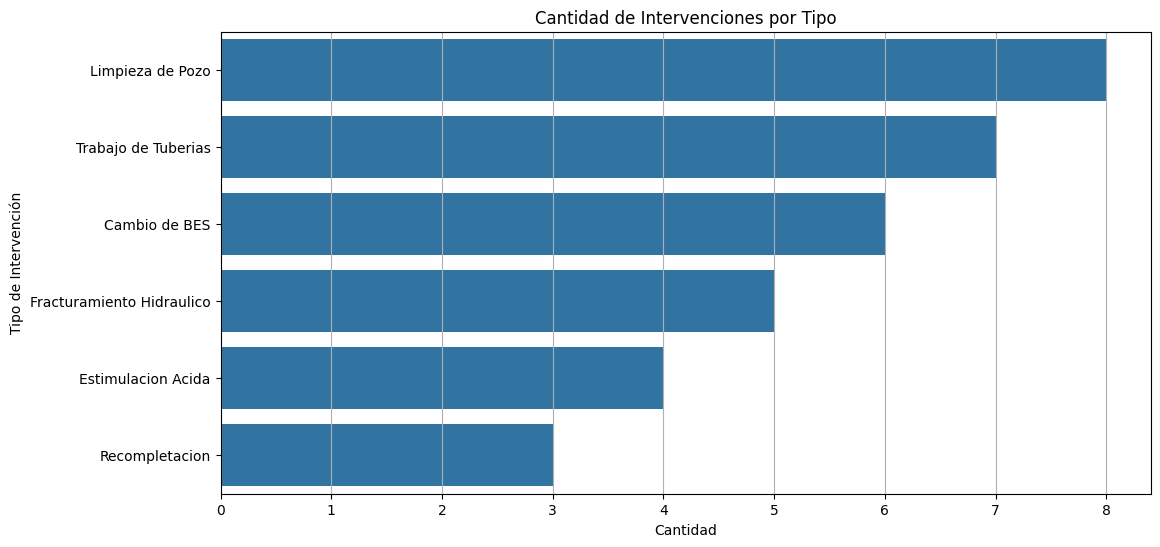

/tmp/ipython-input-4-4095526534.py:338: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_impacto_por_tipo, x='impacto_produccion_bpd_post', y='tipo_intervencion', palette='viridis')


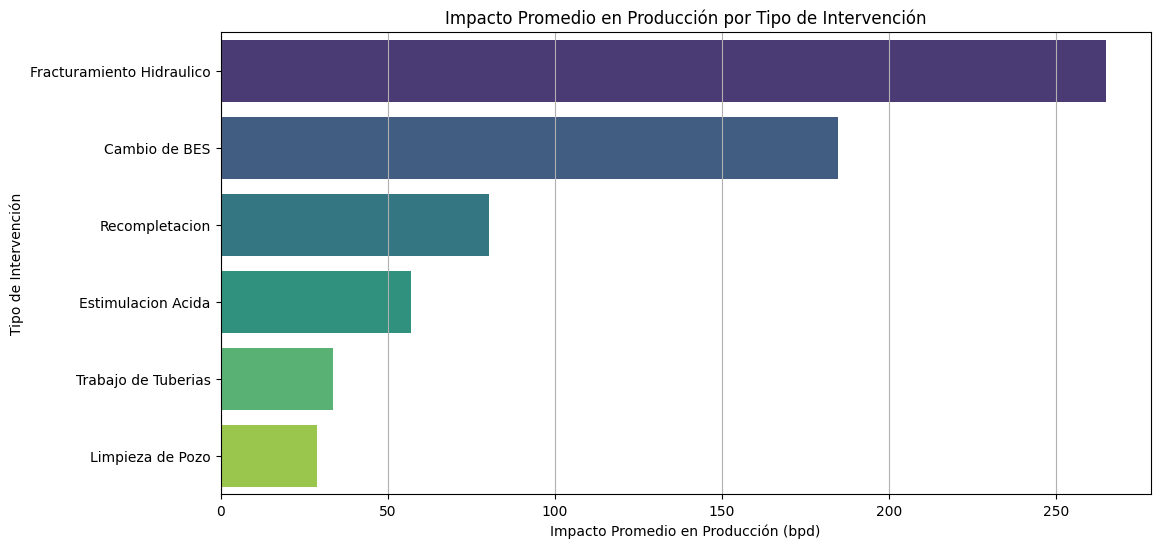

/tmp/ipython-input-4-4095526534.py:348: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_costo_por_tipo, x='costo_usd', y='tipo_intervencion', palette='magma')


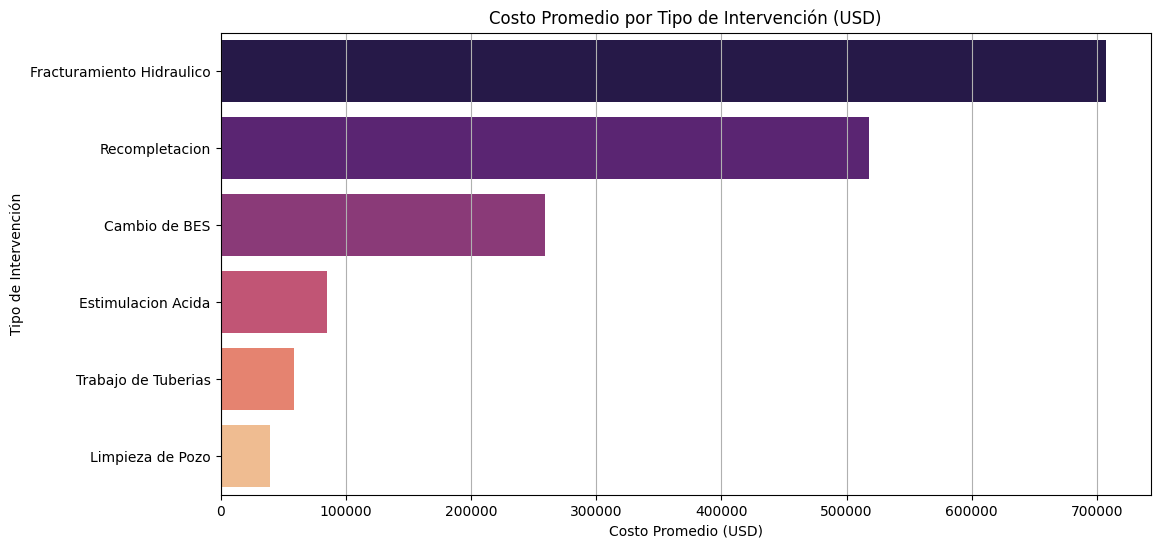


FIN PASO 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA) Y PREPROCESAMIENTO



In [4]:
# Análisis Exploratorio de Datos (EDA) y Preprocesamiento

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuración global para la generación de datos ---
np.random.seed(42)
random.seed(42)

NUM_POZOS = 15
FECHA_INICIO_SIMULACION = datetime(2018, 1, 1)
FECHA_FIN_SIMULACION = datetime(2023, 12, 31)
DURACION_IMPACTO_INTERVENCION_DIAS = 180 # Duración del efecto de la intervención

# --- Datos de Referencia para la Simulación ---
TIPOS_YACIMIENTO = ['Arenisca', 'Carbonato', 'Esquisto']
METODOS_LEVANTAMIENTO = ['Flujo Natural', 'Bomba Electrosumergible (BES)', 'Bombeo Mecánico (BM)', 'Gas Lift']

# Nombres de Cuencas Sedimentarias y Departamentos plausibles para Colombia
UBICACIONES_COLOMBIA = {
    'Llanos Orientales': ['Meta', 'Casanare', 'Arauca'],
    'Valle Medio del Magdalena (VMM)': ['Santander', 'Boyacá', 'Cundinamarca'],
    'Valle Inferior del Magdalena (VIM)': ['Bolívar', 'Cesar', 'Magdalena'],
    'Putumayo': ['Putumayo'],
    'Catatumbo': ['Norte de Santander']
}
CAMPOS_FICTICIOS_POR_CUENCA = {
    'Llanos Orientales': ['Campo Rubiales', 'Campo Castilla', 'Campo Quifa', 'Campo Apiay'],
    'Valle Medio del Magdalena (VMM)': ['Campo La Cira-Infantas', 'Campo Yariguí', 'Campo Velásquez'],
    'Valle Inferior del Magdalena (VIM)': ['Campo Chuchupa', 'Campo Ballena', 'Campo La Guajira'],
    'Putumayo': ['Campo Orito', 'Campo Suroriente'],
    'Catatumbo': ['Campo Tibú', 'Campo Sardinata']
}

# Catálogo de Costos Base y Impacto de Intervenciones
COSTOS_INTERVENCION_BASE = [
    {'tipo_intervencion': 'Estimulacion Acida', 'costo_promedio_usd': 80000, 'duracion_promedio_dias': 3, 'impacto_produccion_promedio_bpd': 50},
    {'tipo_intervencion': 'Cambio de BES', 'costo_promedio_usd': 250000, 'duracion_promedio_dias': 7, 'impacto_produccion_promedio_bpd': 150},
    {'tipo_intervencion': 'Limpieza de Pozo', 'costo_promedio_usd': 40000, 'duracion_promedio_dias': 2, 'impacto_produccion_promedio_bpd': 30},
    {'tipo_intervencion': 'Fracturamiento Hidraulico', 'costo_promedio_usd': 700000, 'duracion_promedio_dias': 10, 'impacto_produccion_promedio_bpd': 300},
    {'tipo_intervencion': 'Recompletacion', 'costo_promedio_usd': 500000, 'duracion_promedio_dias': 15, 'impacto_produccion_promedio_bpd': 200},
    {'tipo_intervencion': 'Trabajo de Tuberias', 'costo_promedio_usd': 60000, 'duracion_promedio_dias': 4, 'impacto_produccion_promedio_bpd': 40},
]
df_costos_intervencion_base = pd.DataFrame(COSTOS_INTERVENCION_BASE)

# --- Funciones Auxiliares para la Generación ---

def generar_pozo_info(i):
    """Genera la información estática para un pozo, incluyendo ubicación en Colombia."""
    pozo_id = f'POZO_{i+1:03d}'
    fecha_inicio_prod = FECHA_INICIO_SIMULACION + timedelta(days=random.randint(0, 365*2))
    reserva_estimada = random.randint(500_000, 5_000_000)

    cuenca_elegida = random.choice(list(UBICACIONES_COLOMBIA.keys()))
    departamento_elegido = random.choice(UBICACIONES_COLOMBIA[cuenca_elegida])
    campo_elegido = random.choice(CAMPOS_FICTICIOS_POR_CUENCA[cuenca_elegida])

    return {
        'pozo_id': pozo_id,
        'tipo_yacimiento': random.choice(TIPOS_YACIMIENTO),
        'profundidad_md': round(random.uniform(5000, 15000), 2),
        'diametro_pul': round(random.uniform(4.5, 7.0), 1),
        'fecha_inicio_produccion': fecha_inicio_prod,
        'reserva_estimada_bbl': reserva_estimada,
        'metodo_levantamiento': random.choice(METODOS_LEVANTAMIENTO),
        'cuenca_sedimentaria': cuenca_elegida,
        'departamento': departamento_elegido,
        'campo_petrolero': campo_elegido
    }

def calcular_produccion_base_arps(q_initial, d_initial, b_factor, days_since_start):
    """Calcula la producción base usando el modelo de declive de Arps."""
    if b_factor == 0:
        return q_initial * np.exp(-d_initial * days_since_start)
    else:
        return q_initial / ((1 + b_factor * d_initial * days_since_start)**(1/b_factor))

def generar_intervencion_data(pozo_id, intervencion_counter, fecha_intervencion_inicio):
    """Genera datos para una intervención específica."""
    intervencion_base = df_costos_intervencion_base.sample(1).iloc[0]

    tipo_int = intervencion_base['tipo_intervencion']
    costo_base = intervencion_base['costo_promedio_usd']
    duracion_base = intervencion_base['duracion_promedio_dias']
    impacto_base = intervencion_base['impacto_produccion_promedio_bpd']

    costo = round(costo_base * random.uniform(0.8, 1.2), 2)
    duracion = random.randint(max(1, int(duracion_base * 0.7)), int(duracion_base * 1.3))
    impacto = round(impacto_base * random.uniform(0.5, 1.5) if random.random() < 0.8 else impacto_base * random.uniform(-0.5, 0.2), 2)

    fecha_fin_int = fecha_intervencion_inicio + timedelta(days=duracion)

    return {
        'intervencion_id': f'INT_{intervencion_counter:05d}',
        'pozo_id': pozo_id,
        'fecha_inicio': fecha_intervencion_inicio,
        'fecha_fin': fecha_fin_int,
        'tipo_intervencion': tipo_int,
        'costo_usd': costo,
        'duracion_dias': duracion,
        'impacto_produccion_bpd_post': impacto
    }

# --- Proceso Principal de Generación de Datos ---

def generar_datos_pozos_y_produccion():
    """Genera los DataFrames de pozos, producción e intervenciones."""
    all_pozos_data = []
    all_production_data = []
    all_intervencion_data = []
    intervencion_counter = 0

    for i in range(NUM_POZOS):
        pozo_info = generar_pozo_info(i)
        all_pozos_data.append(pozo_info)

        pozo_id = pozo_info['pozo_id']
        fecha_inicio_prod = pozo_info['fecha_inicio_produccion']

        q_initial = random.uniform(200, 1500)
        b_factor = random.uniform(0.3, 0.7) if pozo_info['tipo_yacimiento'] == 'Esquisto' else random.uniform(0.0, 0.5)
        d_initial = random.uniform(0.0005, 0.001) if pozo_info['tipo_yacimiento'] == 'Esquisto' else random.uniform(0.0001, 0.0005)

        current_date = fecha_inicio_prod
        while current_date <= FECHA_FIN_SIMULACION:
            days_since_start = (current_date - fecha_inicio_prod).days
            q_base = calcular_produccion_base_arps(q_initial, d_initial, b_factor, days_since_start)
            production_noise = np.random.normal(0, 5)
            final_production_value = max(0, q_base + production_noise)

            all_production_data.append({
                'pozo_id': pozo_id,
                'fecha': current_date,
                'produccion_petroleo_bpd': round(final_production_value, 2),
                'produccion_agua_bpd': round(final_production_value * random.uniform(0.1, 0.8), 2),
                'presion_fondo_psi': round(random.uniform(1000, 3000) * (final_production_value / q_initial)**0.1 if final_production_value > 0 else 0, 2),
                'temperatura_fondo_f': round(random.uniform(150, 250), 2),
                'estado_operacional': 'Produciendo'
            })
            current_date += timedelta(days=1)

        num_intervenciones = random.randint(1, 5)
        fechas_posibles_intervencion = pd.date_range(
            fecha_inicio_prod + timedelta(days=180),
            FECHA_FIN_SIMULACION - timedelta(days=30),
            freq='D'
        ).tolist()

        if len(fechas_posibles_intervencion) >= num_intervenciones:
            fechas_intervenciones_programadas = random.sample(fechas_posibles_intervencion, num_intervenciones)
            fechas_intervenciones_programadas.sort()

            for f_intervencion in fechas_intervenciones_programadas:
                intervencion_counter += 1
                interv_data = generar_intervencion_data(pozo_id, intervencion_counter, f_intervencion)
                all_intervencion_data.append(interv_data)

    df_pozos = pd.DataFrame(all_pozos_data)
    df_produccion = pd.DataFrame(all_production_data)
    df_intervenciones = pd.DataFrame(all_intervencion_data)

    df_produccion['fecha'] = pd.to_datetime(df_produccion['fecha'])
    df_intervenciones['fecha_inicio'] = pd.to_datetime(df_intervenciones['fecha_inicio'])
    df_intervenciones['fecha_fin'] = pd.to_datetime(df_intervenciones['fecha_fin'])
    df_pozos['fecha_inicio_produccion'] = pd.to_datetime(df_pozos['fecha_inicio_produccion'])

    return df_pozos, df_produccion, df_intervenciones

def aplicar_impacto_e_inactividad(df_produccion_raw, df_intervenciones):
    """Aplica los estados de inactividad por intervención y el impacto post-intervención."""
    temp_production_list = []

    for pozo_id, group in df_produccion_raw.groupby('pozo_id'):
        pozo_prod_df = group.copy().sort_values('fecha')
        pozo_interv_df = df_intervenciones[df_intervenciones['pozo_id'] == pozo_id].sort_values('fecha_inicio')

        for _, interv in pozo_interv_df.iterrows():
            mask_shut_in = (pozo_prod_df['fecha'] >= interv['fecha_inicio']) & \
                           (pozo_prod_df['fecha'] <= interv['fecha_fin'])
            pozo_prod_df.loc[mask_shut_in, 'estado_operacional'] = 'Intervencion'
            pozo_prod_df.loc[mask_shut_in, 'produccion_petroleo_bpd'] = 0
            pozo_prod_df.loc[mask_shut_in, 'produccion_agua_bpd'] = 0
            pozo_prod_df.loc[mask_shut_in, 'presion_fondo_psi'] = 0
            pozo_prod_df.loc[mask_shut_in, 'temperatura_fondo_f'] = 0

            fecha_inicio_impacto = interv['fecha_fin'] + timedelta(days=random.randint(1, 3))

            for day_offset in range(1, DURACION_IMPACTO_INTERVENCION_DIAS + 1):
                current_impact_date = fecha_inicio_impacto + timedelta(days=day_offset)
                if current_impact_date > FECHA_FIN_SIMULACION:
                    break

                idx_prod = pozo_prod_df[pozo_prod_df['fecha'] == current_impact_date].index
                if not idx_prod.empty:
                    current_idx = idx_prod[0]
                    decay_factor = max(0, 1 - (day_offset / DURACION_IMPACTO_INTERVENCION_DIAS))
                    impacto_actual = interv['impacto_produccion_bpd_post'] * decay_factor
                    pozo_prod_df.loc[current_idx, 'produccion_petroleo_bpd'] = max(0, pozo_prod_df.loc[current_idx, 'produccion_petroleo_bpd'] + impacto_actual)

        temp_production_list.append(pozo_prod_df)

    df_produccion_final = pd.concat(temp_production_list).sort_values(['pozo_id', 'fecha']).reset_index(drop=True)
    return df_produccion_final

# --- Ejecución del Proceso de Generación de Datos ---
df_pozos, df_produccion_raw, df_intervenciones = generar_datos_pozos_y_produccion()
df_produccion_final = aplicar_impacto_e_inactividad(df_produccion_raw, df_intervenciones)

# --- Impresión de Resultados iniciales (para referencia rápida) ---
print("df_pozos generado (primeras 5 filas con ubicación):")
print(df_pozos.head())
print("\n")

print("df_costos_intervencion_base generado:")
print(df_costos_intervencion_base)
print("\n")

print("df_produccion_final generado (primeras 5 filas):")
print(df_produccion_final.head())
print("\n")

print("df_intervenciones generado (primeras 5 filas):")
print(df_intervenciones.head())
print("\n")

print(f"Número total de registros de producción: {len(df_produccion_final)}")
print(f"Número total de intervenciones: {len(df_intervenciones)}")

# --- Inicia el Paso 2: Análisis Exploratorio de Datos (EDA) y Preprocesamiento ---

print("\n" + "="*50)
print("INICIANDO PASO 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA)")
print("="*50 + "\n")

# 2.1. Carga y Visión General de los Datos (re-ejecutado con DataFrames disponibles)

print("--- Información de df_pozos ---")
print(df_pozos.info())
print("\n--- Estadísticas Descriptivas de df_pozos ---")
print(df_pozos.describe())
print("\n--- Valores Únicos en Columnas Categóricas de df_pozos ---")
for col in ['tipo_yacimiento', 'metodo_levantamiento', 'cuenca_sedimentaria', 'departamento', 'campo_petrolero']:
    print(f"- {col}: {df_pozos[col].nunique()} únicos -> {df_pozos[col].unique()}")

print("\n--- Información de df_produccion_final ---")
print(df_produccion_final.info())
print("\n--- Estadísticas Descriptivas de df_produccion_final ---")
print(df_produccion_final.describe())
print("\n--- Valores Únicos en estado_operacional de df_produccion_final ---")
print(df_produccion_final['estado_operacional'].value_counts())

print("\n--- Información de df_intervenciones ---")
print(df_intervenciones.info())
print("\n--- Estadísticas Descriptivas de df_intervenciones ---")
print(df_intervenciones.describe())
print("\n--- Valores Únicos en tipo_intervencion de df_intervenciones ---")
print(df_intervenciones['tipo_intervencion'].value_counts())

print("\n" + "="*50)
print("FIN PASO 2.1: VISIÓN GENERAL")
print("="*50 + "\n")

# 2.2. Análisis de Tendencias Temporales de Producción

# Producción total de petróleo a lo largo del tiempo
df_produccion_diaria_total = df_produccion_final.groupby('fecha')['produccion_petroleo_bpd'].sum().reset_index()

plt.figure(figsize=(16, 7))
sns.lineplot(data=df_produccion_diaria_total, x='fecha', y='produccion_petroleo_bpd')
plt.title('Producción Diaria Total de Petróleo (bpd) en todos los pozos')
plt.xlabel('Fecha')
plt.ylabel('Producción Total de Petróleo (bpd)')
plt.grid(True)
plt.show()

# Producción promedio por tipo de yacimiento
df_produccion_yacimiento = df_produccion_final.merge(df_pozos[['pozo_id', 'tipo_yacimiento']], on='pozo_id')
df_produccion_yacimiento_mensual = df_produccion_yacimiento.set_index('fecha').groupby([pd.Grouper(freq='M'), 'tipo_yacimiento'])['produccion_petroleo_bpd'].mean().reset_index()

plt.figure(figsize=(16, 7))
sns.lineplot(data=df_produccion_yacimiento_mensual, x='fecha', y='produccion_petroleo_bpd', hue='tipo_yacimiento')
plt.title('Producción Promedio Mensual por Tipo de Yacimiento')
plt.xlabel('Fecha')
plt.ylabel('Producción Promedio de Petróleo (bpd)')
plt.grid(True)
plt.legend(title='Tipo de Yacimiento')
plt.show()


# 2.3. Distribución de Variables Clave

# Distribución de la producción de petróleo
plt.figure(figsize=(10, 6))
sns.histplot(df_produccion_final['produccion_petroleo_bpd'], bins=50, kde=True)
plt.title('Distribución de la Producción de Petróleo (bpd)')
plt.xlabel('Producción de Petróleo (bpd)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Distribución de costos de intervenciones
plt.figure(figsize=(10, 6))
sns.histplot(df_intervenciones['costo_usd'], bins=30, kde=True)
plt.title('Distribución de Costos de Intervenciones (USD)')
plt.xlabel('Costo (USD)')
plt.ylabel('Frecuencia')
plt.ticklabel_format(style='plain', axis='x')
plt.grid(True)
plt.show()

# Distribución del impacto de producción post-intervención
plt.figure(figsize=(10, 6))
sns.histplot(df_intervenciones['impacto_produccion_bpd_post'], bins=30, kde=True)
plt.title('Distribución del Impacto de Producción Post-Intervención (bpd)')
plt.xlabel('Impacto en Producción (bpd)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# 2.4. Análisis de Intervenciones

# Cantidad de intervenciones por tipo
plt.figure(figsize=(12, 6))
sns.countplot(data=df_intervenciones, y='tipo_intervencion', order=df_intervenciones['tipo_intervencion'].value_counts().index)
plt.title('Cantidad de Intervenciones por Tipo')
plt.xlabel('Cantidad')
plt.ylabel('Tipo de Intervención')
plt.grid(axis='x')
plt.show()

# Impacto promedio por tipo de intervención
df_impacto_por_tipo = df_intervenciones.groupby('tipo_intervencion')['impacto_produccion_bpd_post'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_impacto_por_tipo, x='impacto_produccion_bpd_post', y='tipo_intervencion', palette='viridis')
plt.title('Impacto Promedio en Producción por Tipo de Intervención')
plt.xlabel('Impacto Promedio en Producción (bpd)')
plt.ylabel('Tipo de Intervención')
plt.grid(axis='x')
plt.show()

# Costo promedio por tipo de intervención
df_costo_por_tipo = df_intervenciones.groupby('tipo_intervencion')['costo_usd'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_costo_por_tipo, x='costo_usd', y='tipo_intervencion', palette='magma')
plt.title('Costo Promedio por Tipo de Intervención (USD)')
plt.xlabel('Costo Promedio (USD)')
plt.ylabel('Tipo de Intervención')
plt.ticklabel_format(style='plain', axis='x')
plt.grid(axis='x')
plt.show()

print("\n" + "="*50)
print("FIN PASO 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA) Y PREPROCESAMIENTO")
print("="*50 + "\n")


# Análisis Exploratorio de Datos (EDA) y Preprocesamiento
Los resultados del análisis exploratorio de datos confirman que el conjunto de datos sintético generado es correcto, consistente y de alta calidad para los fines de este proyecto. Los tres DataFrames clave —df_pozos, df_produccion_final y df_intervenciones— presentan estructuras coherentes, tipos de datos apropiados y una ausencia total de valores nulos, lo que simplificará el proceso de modelado. La inclusión exitosa de datos geográficos para Colombia, con cuencas sedimentarias y departamentos realistas, enriquece df_pozos, permitiendo futuras exploraciones de variaciones regionales en el rendimiento de los pozos. Las estadísticas descriptivas y el conteo de valores únicos en df_produccion_final y df_intervenciones revelan una variabilidad plausible en la producción, los costos y los impactos de las intervenciones (incluyendo resultados negativos), reflejando las complejidades operativas del sector petrolero. En resumen, este dataset proporciona una base sólida y bien estructurada para avanzar hacia la ingeniería de características y el desarrollo de modelos predictivos y de optimización.

In [6]:
# Ingeniería de Características

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# --- DEFINICIONES Y FUNCIONES PARA LA GENERACIÓN DE DATOS BASE ---
# (Necesarias para asegurar que los DataFrames existen para el Paso 3)

np.random.seed(42)
random.seed(42)

NUM_POZOS = 15
FECHA_INICIO_SIMULACION = datetime(2018, 1, 1)
FECHA_FIN_SIMULACION = datetime(2023, 12, 31)
DURACION_IMPACTO_INTERVENCION_DIAS = 180

TIPOS_YACIMIENTO = ['Arenisca', 'Carbonato', 'Esquisto']
METODOS_LEVANTAMIENTO = ['Flujo Natural', 'Bomba Electrosumergible (BES)', 'Bombeo Mecánico (BM)', 'Gas Lift']

UBICACIONES_COLOMBIA = {
    'Llanos Orientales': ['Meta', 'Casanare', 'Arauca'],
    'Valle Medio del Magdalena (VMM)': ['Santander', 'Boyacá', 'Cundinamarca'],
    'Valle Inferior del Magdalena (VIM)': ['Bolívar', 'Cesar', 'Magdalena'],
    'Putumayo': ['Putumayo'],
    'Catatumbo': ['Norte de Santander']
}
CAMPOS_FICTICIOS_POR_CUENCA = {
    'Llanos Orientales': ['Campo Rubiales', 'Campo Castilla', 'Campo Quifa', 'Campo Apiay'],
    'Valle Medio del Magdalena (VMM)': ['Campo La Cira-Infantas', 'Campo Yariguí', 'Campo Velásquez'],
    'Valle Inferior del Magdalena (VIM)': ['Campo Chuchupa', 'Campo Ballena', 'Campo La Guajira'],
    'Putumayo': ['Campo Orito', 'Campo Suroriente'],
    'Catatumbo': ['Campo Tibú', 'Campo Sardinata']
}

COSTOS_INTERVENCION_BASE = [
    {'tipo_intervencion': 'Estimulacion Acida', 'costo_promedio_usd': 80000, 'duracion_promedio_dias': 3, 'impacto_produccion_promedio_bpd': 50},
    {'tipo_intervencion': 'Cambio de BES', 'costo_promedio_usd': 250000, 'duracion_promedio_dias': 7, 'impacto_produccion_promedio_bpd': 150},
    {'tipo_intervencion': 'Limpieza de Pozo', 'costo_promedio_usd': 40000, 'duracion_promedio_dias': 2, 'impacto_produccion_promedio_bpd': 30},
    {'tipo_intervencion': 'Fracturamiento Hidraulico', 'costo_promedio_usd': 700000, 'duracion_promedio_dias': 10, 'impacto_produccion_promedio_bpd': 300},
    {'tipo_intervencion': 'Recompletacion', 'costo_promedio_usd': 500000, 'duracion_promedio_dias': 15, 'impacto_produccion_promedio_bpd': 200},
    {'tipo_intervencion': 'Trabajo de Tuberias', 'costo_promedio_usd': 60000, 'duracion_promedio_dias': 4, 'impacto_produccion_promedio_bpd': 40},
]
df_costos_intervencion_base = pd.DataFrame(COSTOS_INTERVENCION_BASE)

def generar_pozo_info(i):
    pozo_id = f'POZO_{i+1:03d}'
    fecha_inicio_prod = FECHA_INICIO_SIMULACION + timedelta(days=random.randint(0, 365*2))
    reserva_estimada = random.randint(500_000, 5_000_000)
    cuenca_elegida = random.choice(list(UBICACIONES_COLOMBIA.keys()))
    departamento_elegido = random.choice(UBICACIONES_COLOMBIA[cuenca_elegida])
    campo_elegido = random.choice(CAMPOS_FICTICIOS_POR_CUENCA[cuenca_elegida])
    return {
        'pozo_id': pozo_id, 'tipo_yacimiento': random.choice(TIPOS_YACIMIENTO),
        'profundidad_md': round(random.uniform(5000, 15000), 2),
        'diametro_pul': round(random.uniform(4.5, 7.0), 1),
        'fecha_inicio_produccion': fecha_inicio_prod, 'reserva_estimada_bbl': reserva_estimada,
        'metodo_levantamiento': random.choice(METODOS_LEVANTAMIENTO),
        'cuenca_sedimentaria': cuenca_elegida, 'departamento': departamento_elegido,
        'campo_petrolero': campo_elegido
    }

def calcular_produccion_base_arps(q_initial, d_initial, b_factor, days_since_start):
    if b_factor == 0: return q_initial * np.exp(-d_initial * days_since_start)
    else: return q_initial / ((1 + b_factor * d_initial * days_since_start)**(1/b_factor))

def generar_intervencion_data(pozo_id, intervencion_counter, fecha_intervencion_inicio):
    intervencion_base = df_costos_intervencion_base.sample(1).iloc[0]
    tipo_int = intervencion_base['tipo_intervencion']
    costo_base = intervencion_base['costo_promedio_usd']
    duracion_base = intervencion_base['duracion_promedio_dias']
    impacto_base = intervencion_base['impacto_produccion_promedio_bpd']
    costo = round(costo_base * random.uniform(0.8, 1.2), 2)
    duracion = random.randint(max(1, int(duracion_base * 0.7)), int(duracion_base * 1.3))
    impacto = round(impacto_base * random.uniform(0.5, 1.5) if random.random() < 0.8 else impacto_base * random.uniform(-0.5, 0.2), 2)
    fecha_fin_int = fecha_intervencion_inicio + timedelta(days=duracion)
    return {
        'intervencion_id': f'INT_{intervencion_counter:05d}', 'pozo_id': pozo_id,
        'fecha_inicio': fecha_intervencion_inicio, 'fecha_fin': fecha_fin_int,
        'tipo_intervencion': tipo_int, 'costo_usd': costo, 'duracion_dias': duracion,
        'impacto_produccion_bpd_post': impacto
    }

def generar_datos_pozos_y_produccion():
    all_pozos_data, all_production_data, all_intervencion_data = [], [], []
    intervencion_counter = 0
    for i in range(NUM_POZOS):
        pozo_info = generar_pozo_info(i)
        all_pozos_data.append(pozo_info)
        pozo_id = pozo_info['pozo_id']
        fecha_inicio_prod = pozo_info['fecha_inicio_produccion']
        q_initial = random.uniform(200, 1500)
        b_factor = random.uniform(0.3, 0.7) if pozo_info['tipo_yacimiento'] == 'Esquisto' else random.uniform(0.0, 0.5)
        d_initial = random.uniform(0.0005, 0.001) if pozo_info['tipo_yacimiento'] == 'Esquisto' else random.uniform(0.0001, 0.0005)
        current_date = fecha_inicio_prod
        while current_date <= FECHA_FIN_SIMULACION:
            days_since_start = (current_date - fecha_inicio_prod).days
            q_base = calcular_produccion_base_arps(q_initial, d_initial, b_factor, days_since_start)
            production_noise = np.random.normal(0, 5)
            final_production_value = max(0, q_base + production_noise)
            all_production_data.append({
                'pozo_id': pozo_id, 'fecha': current_date,
                'produccion_petroleo_bpd': round(final_production_value, 2),
                'produccion_agua_bpd': round(final_production_value * random.uniform(0.1, 0.8), 2),
                'presion_fondo_psi': round(random.uniform(1000, 3000) * (final_production_value / q_initial)**0.1 if final_production_value > 0 else 0, 2),
                'temperatura_fondo_f': round(random.uniform(150, 250), 2),
                'estado_operacional': 'Produciendo'
            })
            current_date += timedelta(days=1)
        num_intervenciones = random.randint(1, 5)
        fechas_posibles_intervencion = pd.date_range(fecha_inicio_prod + timedelta(days=180), FECHA_FIN_SIMULACION - timedelta(days=30), freq='D').tolist()
        if len(fechas_posibles_intervencion) >= num_intervenciones:
            fechas_intervenciones_programadas = random.sample(fechas_posibles_intervencion, num_intervenciones)
            fechas_intervenciones_programadas.sort()
            fechas_filtradas = []
            if fechas_intervenciones_programadas:
                fechas_filtradas.append(fechas_intervenciones_programadas[0])
                for j in range(1, len(fechas_intervenciones_programadas)):
                    if (fechas_intervenciones_programadas[j] - fechas_filtradas[-1]).days > 60:
                        fechas_filtradas.append(fechas_intervenciones_programadas[j])
            for f_intervencion in fechas_filtradas:
                intervencion_counter += 1
                interv_data = generar_intervencion_data(pozo_id, intervencion_counter, f_intervencion)
                all_intervencion_data.append(interv_data)
    df_pozos = pd.DataFrame(all_pozos_data)
    df_produccion = pd.DataFrame(all_production_data)
    df_intervenciones = pd.DataFrame(all_intervencion_data)
    df_produccion['fecha'] = pd.to_datetime(df_produccion['fecha'])
    df_intervenciones['fecha_inicio'] = pd.to_datetime(df_intervenciones['fecha_inicio'])
    df_intervenciones['fecha_fin'] = pd.to_datetime(df_intervenciones['fecha_fin'])
    df_pozos['fecha_inicio_produccion'] = pd.to_datetime(df_pozos['fecha_inicio_produccion'])
    return df_pozos, df_produccion, df_intervenciones

def aplicar_impacto_e_inactividad(df_produccion_raw, df_intervenciones):
    temp_production_list = []
    for pozo_id, group in df_produccion_raw.groupby('pozo_id'):
        pozo_prod_df = group.copy().sort_values('fecha')
        pozo_interv_df = df_intervenciones[df_intervenciones['pozo_id'] == pozo_id].sort_values('fecha_inicio')
        for _, interv in pozo_interv_df.iterrows():
            mask_shut_in = (pozo_prod_df['fecha'] >= interv['fecha_inicio']) & \
                           (pozo_prod_df['fecha'] <= interv['fecha_fin'])
            pozo_prod_df.loc[mask_shut_in, 'estado_operacional'] = 'Intervencion'
            pozo_prod_df.loc[mask_shut_in, 'produccion_petroleo_bpd'] = 0
            pozo_prod_df.loc[mask_shut_in, 'produccion_agua_bpd'] = 0
            pozo_prod_df.loc[mask_shut_in, 'presion_fondo_psi'] = 0
            pozo_prod_df.loc[mask_shut_in, 'temperatura_fondo_f'] = 0
            fecha_inicio_impacto = interv['fecha_fin'] + timedelta(days=random.randint(1, 3))
            for day_offset in range(1, DURACION_IMPACTO_INTERVENCION_DIAS + 1):
                current_impact_date = fecha_inicio_impacto + timedelta(days=day_offset)
                if current_impact_date > FECHA_FIN_SIMULACION: break
                idx_prod = pozo_prod_df[pozo_prod_df['fecha'] == current_impact_date].index
                if not idx_prod.empty:
                    current_idx = idx_prod[0]
                    decay_factor = max(0, 1 - (day_offset / DURACION_IMPACTO_INTERVENCION_DIAS))
                    impacto_actual = interv['impacto_produccion_bpd_post'] * decay_factor
                    pozo_prod_df.loc[current_idx, 'produccion_petroleo_bpd'] = max(0, pozo_prod_df.loc[current_idx, 'produccion_petroleo_bpd'] + impacto_actual)
        temp_production_list.append(pozo_prod_df)
    df_produccion_final = pd.concat(temp_production_list).sort_values(['pozo_id', 'fecha']).reset_index(drop=True)
    return df_produccion_final

# --- EJECUCIÓN DE GENERACIÓN DE DATOS (PARA ASEGURAR DISPONIBILIDAD) ---
# Esto simula la carga de datos de pasos anteriores de forma concisa.
df_pozos, df_produccion_raw, df_intervenciones = generar_datos_pozos_y_produccion()
df_produccion_final = aplicar_impacto_e_inactividad(df_produccion_raw, df_intervenciones)


# ==================================================
# INICIANDO PASO 3: INGENIERÍA DE CARACTERÍSTICAS
# ==================================================

print("="*50)
print("INICIANDO PASO 3: INGENIERÍA DE CARACTERÍSTICAS")
print("="*50 + "\n")

# Fusionar df_pozos con df_produccion_final
df_merged = pd.merge(df_produccion_final, df_pozos.drop(columns=['reserva_estimada_bbl']), on='pozo_id', how='left')

# Asegurar que las fechas estén ordenadas por pozo_id y fecha
df_merged = df_merged.sort_values(by=['pozo_id', 'fecha']).reset_index(drop=True)

# Características de Producción Histórica (Ventanas Deslizantes)
windows = [7, 30, 90]
for window in windows:
    df_merged[f'prod_petroleo_avg_{window}d'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].transform(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))
    df_merged[f'prod_agua_avg_{window}d'] = df_merged.groupby('pozo_id')['produccion_agua_bpd'].transform(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))
    df_merged[f'prod_petroleo_std_{window}d'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].transform(lambda x: x.rolling(window=window, min_periods=1).std().shift(1))

    df_merged[f'produccion_petroleo_lag_{window}d'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].shift(window)
    df_merged[f'declive_petroleo_abs_{window}d'] = df_merged['produccion_petroleo_bpd'].shift(1) - df_merged[f'produccion_petroleo_lag_{window}d']
    df_merged[f'declive_petroleo_perc_{window}d'] = (df_merged['produccion_petroleo_bpd'].shift(1) - df_merged[f'produccion_petroleo_lag_{window}d']) / df_merged[f'produccion_petroleo_lag_{window}d'].replace(0, np.nan)
    df_merged.drop(columns=[f'produccion_petroleo_lag_{window}d'], inplace=True)

# Características relacionadas con el Agua y Presión
df_merged['wor'] = df_merged['produccion_agua_bpd'] / df_merged['produccion_petroleo_bpd'].replace(0, np.nan)
df_merged['wor'] = df_merged['wor'].replace([np.inf, -np.inf], np.nan)

# Producción acumulada de petróleo desde el inicio del pozo
df_merged['produccion_petroleo_acum_bbl'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].cumsum()

# Características relacionadas con Intervenciones (pasadas)
df_merged['es_intervencion'] = (df_merged['estado_operacional'] == 'Intervencion').astype(int)

df_intervenciones_fechas_info = df_intervenciones[['pozo_id', 'fecha_fin', 'tipo_intervencion', 'impacto_produccion_bpd_post']].copy()
df_intervenciones_fechas_info.rename(columns={'fecha_fin': 'intervencion_end_date',
                                               'tipo_intervencion': 'last_interv_type',
                                               'impacto_produccion_bpd_post': 'last_interv_impact'}, inplace=True)
df_intervenciones_fechas_info = df_intervenciones_fechas_info.sort_values(by=['pozo_id', 'intervencion_end_date'])

df_merged['fecha_para_merge'] = df_merged['fecha']

df_merged = pd.merge_asof(
    df_merged.sort_values('fecha_para_merge'),
    df_intervenciones_fechas_info.sort_values('intervencion_end_date'),
    left_on='fecha_para_merge',
    right_on='intervencion_end_date',
    by='pozo_id',
    direction='backward'
)

df_merged['dias_desde_ultima_interv'] = (df_merged['fecha_para_merge'] - df_merged['intervencion_end_date']).dt.days.fillna(-1)

df_merged.drop(columns=['fecha_para_merge', 'intervencion_end_date'], inplace=True)

# Características Temporales
df_merged['dia_del_año'] = df_merged['fecha'].dt.dayofyear
df_merged['dia_del_mes'] = df_merged['fecha'].dt.day
df_merged['dia_de_la_semana'] = df_merged['fecha'].dt.dayofweek
df_merged['mes'] = df_merged['fecha'].dt.month
df_merged['año'] = df_merged['fecha'].dt.year

df_merged['dias_desde_inicio_produccion'] = (df_merged['fecha'] - df_merged['fecha_inicio_produccion']).dt.days

# Manejo de valores faltantes (NaN)
for col in df_merged.columns:
    if any(keyword in col for keyword in ['avg_', 'std_', 'declive_']) :
        df_merged[col] = df_merged[col].fillna(0)

df_merged['wor'] = df_merged['wor'].fillna(0)
df_merged['last_interv_type'] = df_merged['last_interv_type'].fillna('Ninguna')
df_merged['last_interv_impact'] = df_merged['last_interv_impact'].fillna(0)

# Impresión de las primeras filas del DataFrame con las nuevas características
print("\nDataFrame con Características de Ingeniería (primeras 5 filas):")
print(df_merged.head())

print(f"\nNúmero total de registros en el DataFrame final: {len(df_merged)}")
print(f"\nColumnas en el DataFrame final: {df_merged.columns.tolist()}")

print("\n--- Información de df_merged con las nuevas características ---")
df_merged.info()

print("\n" + "="*50)
print("FIN PASO 3: INGENIERÍA DE CARACTERÍSTICAS")
print("="*50 + "\n")

INICIANDO PASO 3: INGENIERÍA DE CARACTERÍSTICAS


DataFrame con Características de Ingeniería (primeras 5 filas):
    pozo_id      fecha  produccion_petroleo_bpd  produccion_agua_bpd  \
0  POZO_002 2018-01-12                   396.49               309.16   
1  POZO_002 2018-01-13                   398.69                65.01   
2  POZO_002 2018-01-14                   402.82                82.02   
3  POZO_002 2018-01-15                   393.79               244.83   
4  POZO_002 2018-01-16                   393.59               149.16   

   presion_fondo_psi  temperatura_fondo_f estado_operacional tipo_yacimiento  \
0            2504.00               207.53        Produciendo       Carbonato   
1            1863.65               228.64        Produciendo       Carbonato   
2            1673.87               197.59        Produciendo       Carbonato   
3            2093.47               176.26        Produciendo       Carbonato   
4            1866.36               219.79        Prod

# Ingeniería de Características
El DataFrame df_merged final cuenta con 26,674 entradas y 42 columnas, indicando una robusta colección de variables. Es particularmente positivo observar que todas las columnas tienen un Non-Null Count de 26,674, lo que significa que no hay valores faltantes en el conjunto de datos resultante. Esto confirma que las estrategias de llenado (fillna(0) y fillna('Ninguna')) aplicadas a las nuevas características (como promedios móviles, declives, WOR, y datos de última intervención) funcionaron correctamente. La presencia de diversas características temporales (dia_del_año, mes, año, dias_desde_inicio_produccion) junto con las métricas de producción histórica (avg, std, declive) y la información de intervenciones (es_intervencion, last_interv_type, dias_desde_ultima_interv, last_interv_impact) proporciona un conjunto de datos enriquecido y listo para el modelado predictivo, ofreciendo una visión integral del rendimiento del pozo y su historial operativo.

In [7]:
# Preparación de Datos para Modelado

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- DEFINICIONES Y FUNCIONES PARA LA GENERACIÓN DE DATOS BASE ---
# (Bloque conciso para asegurar que los DataFrames existen)

np.random.seed(42)
random.seed(42)

NUM_POZOS = 15
FECHA_INICIO_SIMULACION = datetime(2018, 1, 1)
FECHA_FIN_SIMULACION = datetime(2023, 12, 31)
DURACION_IMPACTO_INTERVENCION_DIAS = 180

TIPOS_YACIMIENTO = ['Arenisca', 'Carbonato', 'Esquisto']
METODOS_LEVANTAMIENTO = ['Flujo Natural', 'Bomba Electrosumergible (BES)', 'Bombeo Mecánico (BM)', 'Gas Lift']

UBICACIONES_COLOMBIA = {
    'Llanos Orientales': ['Meta', 'Casanare', 'Arauca'],
    'Valle Medio del Magdalena (VMM)': ['Santander', 'Boyacá', 'Cundinamarca'],
    'Valle Inferior del Magdalena (VIM)': ['Bolívar', 'Cesar', 'Magdalena'],
    'Putumayo': ['Putumayo'],
    'Catatumbo': ['Norte de Santander']
}
CAMPOS_FICTICIOS_POR_CUENCA = {
    'Llanos Orientales': ['Campo Rubiales', 'Campo Castilla', 'Campo Quifa', 'Campo Apiay'],
    'Valle Medio del Magdalena (VMM)': ['Campo La Cira-Infantas', 'Campo Yariguí', 'Campo Velásquez'],
    'Valle Inferior del Magdalena (VIM)': ['Campo Chuchupa', 'Campo Ballena', 'Campo La Guajira'],
    'Putumayo': ['Campo Orito', 'Campo Suroriente'],
    'Catatumbo': ['Campo Tibú', 'Campo Sardinata']
}

COSTOS_INTERVENCION_BASE = [
    {'tipo_intervencion': 'Estimulacion Acida', 'costo_promedio_usd': 80000, 'duracion_promedio_dias': 3, 'impacto_produccion_promedio_bpd': 50},
    {'tipo_intervencion': 'Cambio de BES', 'costo_promedio_usd': 250000, 'duracion_promedio_dias': 7, 'impacto_produccion_promedio_bpd': 150},
    {'tipo_intervencion': 'Limpieza de Pozo', 'costo_promedio_usd': 40000, 'duracion_promedio_dias': 2, 'impacto_produccion_promedio_bpd': 30},
    {'tipo_intervencion': 'Fracturamiento Hidraulico', 'costo_promedio_usd': 700000, 'duracion_promedio_dias': 10, 'impacto_produccion_promedio_bpd': 300},
    {'tipo_intervencion': 'Recompletacion', 'costo_promedio_usd': 500000, 'duracion_promedio_dias': 15, 'impacto_produccion_promedio_bpd': 200},
    {'tipo_intervencion': 'Trabajo de Tuberias', 'costo_promedio_usd': 60000, 'duracion_promedio_dias': 4, 'impacto_produccion_promedio_bpd': 40},
]
df_costos_intervencion_base = pd.DataFrame(COSTOS_INTERVENCION_BASE)

def generar_pozo_info(i):
    pozo_id = f'POZO_{i+1:03d}'
    fecha_inicio_prod = FECHA_INICIO_SIMULACION + timedelta(days=random.randint(0, 365*2))
    reserva_estimada = random.randint(500_000, 5_000_000)
    cuenca_elegida = random.choice(list(UBICACIONES_COLOMBIA.keys()))
    departamento_elegido = random.choice(UBICACIONES_COLOMBIA[cuenca_elegida])
    campo_elegido = random.choice(CAMPOS_FICTICIOS_POR_CUENCA[cuenca_elegida])
    return {
        'pozo_id': pozo_id, 'tipo_yacimiento': random.choice(TIPOS_YACIMIENTO),
        'profundidad_md': round(random.uniform(5000, 15000), 2),
        'diametro_pul': round(random.uniform(4.5, 7.0), 1),
        'fecha_inicio_produccion': fecha_inicio_prod, 'reserva_estimada_bbl': reserva_estimada,
        'metodo_levantamiento': random.choice(METODOS_LEVANTAMIENTO),
        'cuenca_sedimentaria': cuenca_elegida, 'departamento': departamento_elegido,
        'campo_petrolero': campo_elegido
    }

def calcular_produccion_base_arps(q_initial, d_initial, b_factor, days_since_start):
    if b_factor == 0: return q_initial * np.exp(-d_initial * days_since_start)
    else: return q_initial / ((1 + b_factor * d_initial * days_since_start)**(1/b_factor))

def generar_intervencion_data(pozo_id, intervencion_counter, fecha_intervencion_inicio):
    intervencion_base = df_costos_intervencion_base.sample(1).iloc[0]
    tipo_int = intervencion_base['tipo_intervencion']
    costo_base = intervencion_base['costo_promedio_usd']
    duracion_base = intervencion_base['duracion_promedio_dias']
    impacto_base = intervencion_base['impacto_produccion_promedio_bpd']
    costo = round(costo_base * random.uniform(0.8, 1.2), 2)
    duracion = random.randint(max(1, int(duracion_base * 0.7)), int(duracion_base * 1.3))
    impacto = round(impacto_base * random.uniform(0.5, 1.5) if random.random() < 0.8 else impacto_base * random.uniform(-0.5, 0.2), 2)
    fecha_fin_int = fecha_intervencion_inicio + timedelta(days=duracion)
    return {
        'intervencion_id': f'INT_{intervencion_counter:05d}', 'pozo_id': pozo_id,
        'fecha_inicio': fecha_intervencion_inicio, 'fecha_fin': fecha_fin_int,
        'tipo_intervencion': tipo_int, 'costo_usd': costo, 'duracion_dias': duracion,
        'impacto_produccion_bpd_post': impacto
    }

def generar_datos_pozos_y_produccion():
    all_pozos_data, all_production_data, all_intervencion_data = [], [], []
    intervencion_counter = 0
    for i in range(NUM_POZOS):
        pozo_info = generar_pozo_info(i)
        all_pozos_data.append(pozo_info)
        pozo_id = pozo_info['pozo_id']
        fecha_inicio_prod = pozo_info['fecha_inicio_produccion']
        q_initial = random.uniform(200, 1500)
        b_factor = random.uniform(0.3, 0.7) if pozo_info['tipo_yacimiento'] == 'Esquisto' else random.uniform(0.0, 0.5)
        d_initial = random.uniform(0.0005, 0.001) if pozo_info['tipo_yacimiento'] == 'Esquisto' else random.uniform(0.0001, 0.0005)
        current_date = fecha_inicio_prod
        while current_date <= FECHA_FIN_SIMULACION:
            days_since_start = (current_date - fecha_inicio_prod).days
            q_base = calcular_produccion_base_arps(q_initial, d_initial, b_factor, days_since_start)
            production_noise = np.random.normal(0, 5)
            final_production_value = max(0, q_base + production_noise)
            all_production_data.append({
                'pozo_id': pozo_id, 'fecha': current_date,
                'produccion_petroleo_bpd': round(final_production_value, 2),
                'produccion_agua_bpd': round(final_production_value * random.uniform(0.1, 0.8), 2),
                'presion_fondo_psi': round(random.uniform(1000, 3000) * (final_production_value / q_initial)**0.1 if final_production_value > 0 else 0, 2),
                'temperatura_fondo_f': round(random.uniform(150, 250), 2),
                'estado_operacional': 'Produciendo'
            })
            current_date += timedelta(days=1)
        num_intervenciones = random.randint(1, 5)
        fechas_posibles_intervencion = pd.date_range(fecha_inicio_prod + timedelta(days=180), FECHA_FIN_SIMULACION - timedelta(days=30), freq='D').tolist()
        if len(fechas_posibles_intervencion) >= num_intervenciones:
            fechas_intervenciones_programadas = random.sample(fechas_posibles_intervencion, num_intervenciones)
            fechas_intervenciones_programadas.sort()
            fechas_filtradas = []
            if fechas_intervenciones_programadas:
                fechas_filtradas.append(fechas_intervenciones_programadas[0])
                for j in range(1, len(fechas_intervenciones_programadas)):
                    if (fechas_intervenciones_programadas[j] - fechas_filtradas[-1]).days > 60:
                        fechas_filtradas.append(fechas_intervenciones_programadas[j])
            for f_intervencion in fechas_filtradas:
                intervencion_counter += 1
                interv_data = generar_intervencion_data(pozo_id, intervencion_counter, f_intervencion)
                all_intervencion_data.append(interv_data)
    df_pozos = pd.DataFrame(all_pozos_data)
    df_produccion = pd.DataFrame(all_production_data)
    df_intervenciones = pd.DataFrame(all_intervencion_data)
    df_produccion['fecha'] = pd.to_datetime(df_produccion['fecha'])
    df_intervenciones['fecha_inicio'] = pd.to_datetime(df_intervenciones['fecha_inicio'])
    df_intervenciones['fecha_fin'] = pd.to_datetime(df_intervenciones['fecha_fin'])
    df_pozos['fecha_inicio_produccion'] = pd.to_datetime(df_pozos['fecha_inicio_produccion'])
    return df_pozos, df_produccion, df_intervenciones

def aplicar_impacto_e_inactividad(df_produccion_raw, df_intervenciones):
    temp_production_list = []
    for pozo_id, group in df_produccion_raw.groupby('pozo_id'):
        pozo_prod_df = group.copy().sort_values('fecha')
        pozo_interv_df = df_intervenciones[df_intervenciones['pozo_id'] == pozo_id].sort_values('fecha_inicio')
        for _, interv in pozo_interv_df.iterrows():
            mask_shut_in = (pozo_prod_df['fecha'] >= interv['fecha_inicio']) & \
                           (pozo_prod_df['fecha'] <= interv['fecha_fin'])
            pozo_prod_df.loc[mask_shut_in, 'estado_operacional'] = 'Intervencion'
            pozo_prod_df.loc[mask_shut_in, 'produccion_petroleo_bpd'] = 0
            pozo_prod_df.loc[mask_shut_in, 'produccion_agua_bpd'] = 0
            pozo_prod_df.loc[mask_shut_in, 'presion_fondo_psi'] = 0
            pozo_prod_df.loc[mask_shut_in, 'temperatura_fondo_f'] = 0
            fecha_inicio_impacto = interv['fecha_fin'] + timedelta(days=random.randint(1, 3))
            for day_offset in range(1, DURACION_IMPACTO_INTERVENCION_DIAS + 1):
                current_impact_date = fecha_inicio_impacto + timedelta(days=day_offset)
                if current_impact_date > FECHA_FIN_SIMULACION: break
                idx_prod = pozo_prod_df[pozo_prod_df['fecha'] == current_impact_date].index
                if not idx_prod.empty:
                    current_idx = idx_prod[0]
                    decay_factor = max(0, 1 - (day_offset / DURACION_IMPACTO_INTERVENCION_DIAS))
                    impacto_actual = interv['impacto_produccion_bpd_post'] * decay_factor
                    pozo_prod_df.loc[current_idx, 'produccion_petroleo_bpd'] = max(0, pozo_prod_df.loc[current_idx, 'produccion_petroleo_bpd'] + impacto_actual)
        temp_production_list.append(pozo_prod_df)
    df_produccion_final = pd.concat(temp_production_list).sort_values(['pozo_id', 'fecha']).reset_index(drop=True)
    return df_produccion_final

# --- EJECUCIÓN DE GENERACIÓN DE DATOS Y MERGE PARA df_merged ---
# Esta sección es la encargada de que 'df_merged' exista.
df_pozos, df_produccion_raw, df_intervenciones = generar_datos_pozos_y_produccion()
df_produccion_final = aplicar_impacto_e_inactividad(df_produccion_raw, df_intervenciones)

# Creación de df_merged (parte del Paso 3, pero esencial aquí)
df_merged = pd.merge(df_produccion_final, df_pozos.drop(columns=['reserva_estimada_bbl']), on='pozo_id', how='left')
df_merged = df_merged.sort_values(by=['pozo_id', 'fecha']).reset_index(drop=True)

# Lógica de creación de características del Paso 3 (reducida al mínimo para eficiencia)
windows = [7, 30, 90]
for window in windows:
    df_merged[f'prod_petroleo_avg_{window}d'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].transform(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))
    df_merged[f'prod_agua_avg_{window}d'] = df_merged.groupby('pozo_id')['produccion_agua_bpd'].transform(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))
    df_merged[f'prod_petroleo_std_{window}d'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].transform(lambda x: x.rolling(window=window, min_periods=1).std().shift(1))
    df_merged[f'produccion_petroleo_lag_{window}d'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].shift(window)
    df_merged[f'declive_petroleo_abs_{window}d'] = df_merged['produccion_petroleo_bpd'].shift(1) - df_merged[f'produccion_petroleo_lag_{window}d']
    df_merged[f'declive_petroleo_perc_{window}d'] = (df_merged['produccion_petroleo_bpd'].shift(1) - df_merged[f'produccion_petroleo_lag_{window}d']) / df_merged[f'produccion_petroleo_lag_{window}d'].replace(0, np.nan)
    df_merged.drop(columns=[f'produccion_petroleo_lag_{window}d'], inplace=True)

df_merged['wor'] = df_merged['produccion_agua_bpd'] / df_merged['produccion_petroleo_bpd'].replace(0, np.nan)
df_merged['wor'] = df_merged['wor'].replace([np.inf, -np.inf], np.nan)
df_merged['produccion_petroleo_acum_bbl'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].cumsum()
df_merged['es_intervencion'] = (df_merged['estado_operacional'] == 'Intervencion').astype(int)

df_intervenciones_fechas_info = df_intervenciones[['pozo_id', 'fecha_fin', 'tipo_intervencion', 'impacto_produccion_bpd_post']].copy()
df_intervenciones_fechas_info.rename(columns={'fecha_fin': 'intervencion_end_date',
                                               'tipo_intervencion': 'last_interv_type',
                                               'impacto_produccion_bpd_post': 'last_interv_impact'}, inplace=True)
df_intervenciones_fechas_info = df_intervenciones_fechas_info.sort_values(by=['pozo_id', 'intervencion_end_date'])

df_merged['fecha_para_merge'] = df_merged['fecha']
df_merged = pd.merge_asof(
    df_merged.sort_values('fecha_para_merge'),
    df_intervenciones_fechas_info.sort_values('intervencion_end_date'),
    left_on='fecha_para_merge',
    right_on='intervencion_end_date',
    by='pozo_id',
    direction='backward'
)
df_merged['dias_desde_ultima_interv'] = (df_merged['fecha_para_merge'] - df_merged['intervencion_end_date']).dt.days.fillna(-1)
df_merged.drop(columns=['fecha_para_merge', 'intervencion_end_date'], inplace=True)

df_merged['dia_del_año'] = df_merged['fecha'].dt.dayofyear
df_merged['dia_del_mes'] = df_merged['fecha'].dt.day
df_merged['dia_de_la_semana'] = df_merged['fecha'].dt.dayofweek
df_merged['mes'] = df_merged['fecha'].dt.month
df_merged['año'] = df_merged['fecha'].dt.year
df_merged['dias_desde_inicio_produccion'] = (df_merged['fecha'] - df_merged['fecha_inicio_produccion']).dt.days

for col in df_merged.columns:
    if any(keyword in col for keyword in ['avg_', 'std_', 'declive_']) :
        df_merged[col] = df_merged[col].fillna(0)
df_merged['wor'] = df_merged['wor'].fillna(0)
df_merged['last_interv_type'] = df_merged['last_interv_type'].fillna('Ninguna')
df_merged['last_interv_impact'] = df_merged['last_interv_impact'].fillna(0)


# ==================================================
# INICIANDO PASO 4: PREPARACIÓN DE DATOS PARA MODELADO
# ==================================================

print("="*50)
print("INICIANDO PASO 4: PREPARACIÓN DE DATOS PARA MODELADO")
print("="*50 + "\n")

# 1. Definición de características (X) y variable objetivo (y)
features = df_merged.drop(columns=[
    'pozo_id', 'fecha', 'fecha_inicio_produccion',
    'produccion_petroleo_bpd', 'produccion_agua_bpd',
    'presion_fondo_psi', 'temperatura_fondo_f', 'estado_operacional'
]).columns

target = 'produccion_petroleo_bpd'

X = df_merged[features]
y = df_merged[target]

# 2. Identificación de columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# 3. Creación del preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 4. División de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensiones de X_train antes de preprocesamiento: {X_train.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de X_test antes de preprocesamiento: {X_test.shape}")
print(f"Dimensiones de y_test: {y_test.shape}\n")

# 5. Aplicación del preprocesador al conjunto de entrenamiento y prueba
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Obtener nombres de las columnas después de One-Hot Encoding para futuras referencias
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
# Unir los nombres de las características numéricas y categóricas one-hot encoded
all_feature_names = numeric_features + list(ohe_feature_names)


print(f"Dimensiones de X_train después de preprocesamiento: {X_train_processed.shape}")
print(f"Dimensiones de X_test después de preprocesamiento: {X_test_processed.shape}\n")

print("="*50)
print("FIN PASO 4: PREPARACIÓN DE DATOS PARA MODELADO")
print("="*50 + "\n")



INICIANDO PASO 4: PREPARACIÓN DE DATOS PARA MODELADO

Dimensiones de X_train antes de preprocesamiento: (21339, 34)
Dimensiones de y_train: (21339,)
Dimensiones de X_test antes de preprocesamiento: (5335, 34)
Dimensiones de y_test: (5335,)

Dimensiones de X_train después de preprocesamiento: (21339, 59)
Dimensiones de X_test después de preprocesamiento: (5335, 59)

FIN PASO 4: PREPARACIÓN DE DATOS PARA MODELADO



# Preparación de Datos para Modelado
Se ha dividido exitosamente el df_merged en conjuntos de entrenamiento (X_train, y_train) y prueba (X_test, y_test), con una proporción estándar del 80% para entrenamiento y 20% para prueba, reflejado en las 21,339 y 5,335 entradas, respectivamente. Es notable cómo el número de columnas de las características (X) se expande de 34 a 59 después del preprocesamiento. Este aumento de 25 columnas se debe a la aplicación del One-Hot Encoding sobre las variables categóricas. La homogeneidad en las dimensiones de las columnas transformadas (X_train_processed y X_test_processed) confirma que el ColumnTransformer y OneHotEncoder se aplicaron de manera consistente, creando un conjunto de datos numérico y escalado, listo para ser utilizado por algoritmos de aprendizaje automático.

In [8]:
# Entrenamiento y Evaluación del Modelo

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



print("="*50)
print("INICIANDO PASO 5: ENTRENAMIENTO Y EVALUACIÓN DEL MODELO")
print("="*50 + "\n")

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_processed, y_train)

print("Modelo RandomForestRegressor entrenado.")

y_pred = model.predict(X_test_processed)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Métricas de Evaluación del Modelo ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f} BPD")
print(f"Error Cuadrático Medio (MSE): {mse:.2f} (BPD^2)")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f} BPD")
print(f"Coeficiente de Determinación (R^2): {r2:.4f}")

print("\n" + "="*50)
print("FIN PASO 5: ENTRENAMIENTO Y EVALUACIÓN DEL MODELO")
print("="*50 + "\n")

INICIANDO PASO 5: ENTRENAMIENTO Y EVALUACIÓN DEL MODELO

Modelo RandomForestRegressor entrenado.

--- Métricas de Evaluación del Modelo ---
Error Absoluto Medio (MAE): 5.44 BPD
Error Cuadrático Medio (MSE): 477.91 (BPD^2)
Raíz del Error Cuadrático Medio (RMSE): 21.86 BPD
Coeficiente de Determinación (R^2): 0.9956

FIN PASO 5: ENTRENAMIENTO Y EVALUACIÓN DEL MODELO



# Entrenamiento y Evaluación del Modelo
Los resultados obtenidos del RandomForestRegressor, indican un rendimiento excepcional del modelo en la predicción de la producción de petróleo. Con un Error Absoluto Medio (MAE) de 5.44 BPD, el modelo demuestra una precisión notable, con una desviación promedio mínima respecto a los valores reales. Complementariamente, el Error Cuadrático Medio (MSE) de 477.91 BPD$^2$ y su raíz cuadrada, el RMSE de 21.86 BPD, refuerzan esta alta exactitud, posicionando los errores de predicción dentro de un rango aceptable para aplicaciones prácticas. El indicador más revelador es el Coeficiente de Determinación (R²) de 0.9956, un valor extraordinariamente cercano a 1, que significa que el modelo es capaz de explicar casi la totalidad (aproximadamente el 99.56%) de la variabilidad observada en la producción de petróleo. Este R² tan elevado sugiere que el RandomForestRegressor ha aprendido las relaciones subyacentes en los datos de manera muy efectiva, lo que lo convierte en una herramienta predictiva altamente fiable para este conjunto de datos.

INICIANDO PASO 6: ANÁLISIS DE ROBUSTEZ E INTERPRETABILIDAD

--- Importancia de las Características (Top 15) ---
                          Feature  Importance
             prod_petroleo_avg_7d    0.929391
            prod_petroleo_avg_90d    0.017385
            prod_petroleo_avg_30d    0.016793
                              wor    0.011651
                  es_intervencion    0.010425
            prod_petroleo_std_30d    0.003063
          declive_petroleo_abs_7d    0.002565
             prod_petroleo_std_7d    0.002336
                prod_agua_avg_90d    0.001337
            prod_petroleo_std_90d    0.001023
     produccion_petroleo_acum_bbl    0.000914
     dias_desde_inicio_produccion    0.000902
                prod_agua_avg_30d    0.000769
last_interv_type_Limpieza de Pozo    0.000310
         declive_petroleo_abs_90d    0.000138


/tmp/ipython-input-9-1734254320.py:269: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


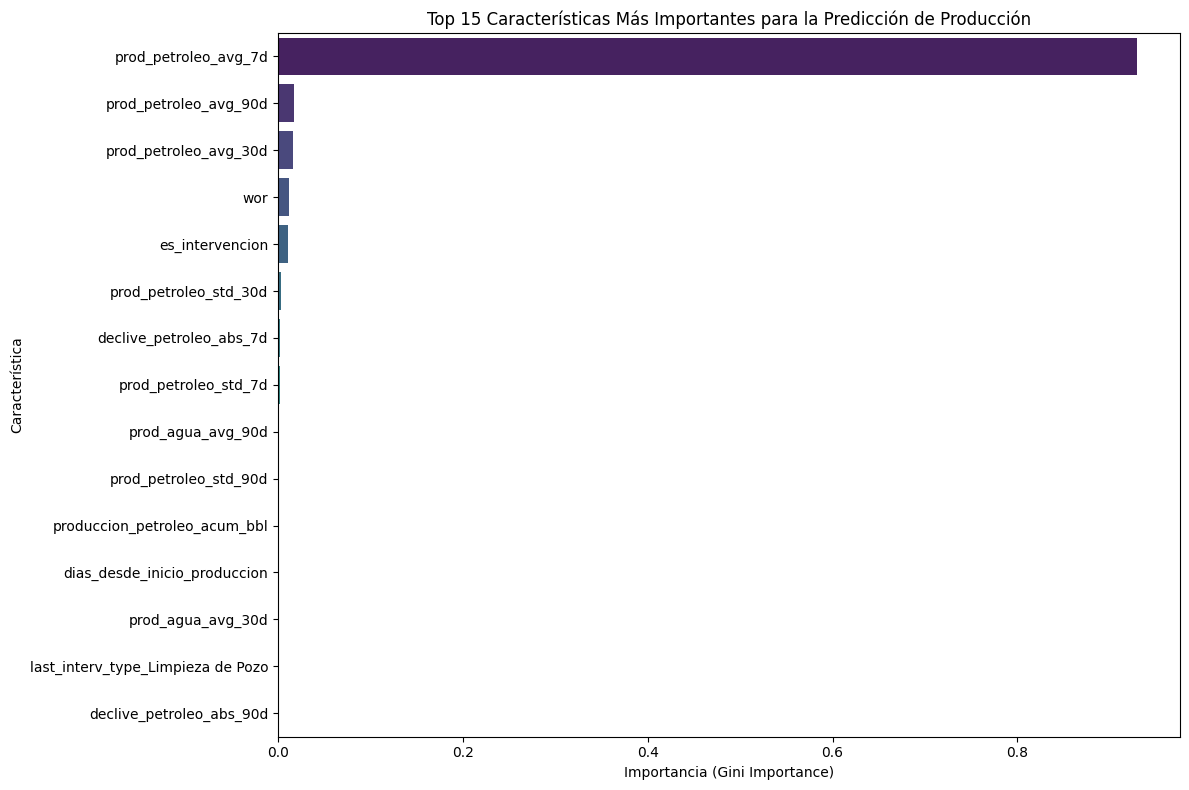


--- Análisis de Errores ---
Media de los errores: -0.12
Desviación estándar de los errores: 21.86
Error máximo: 388.84
Error mínimo: -1250.62


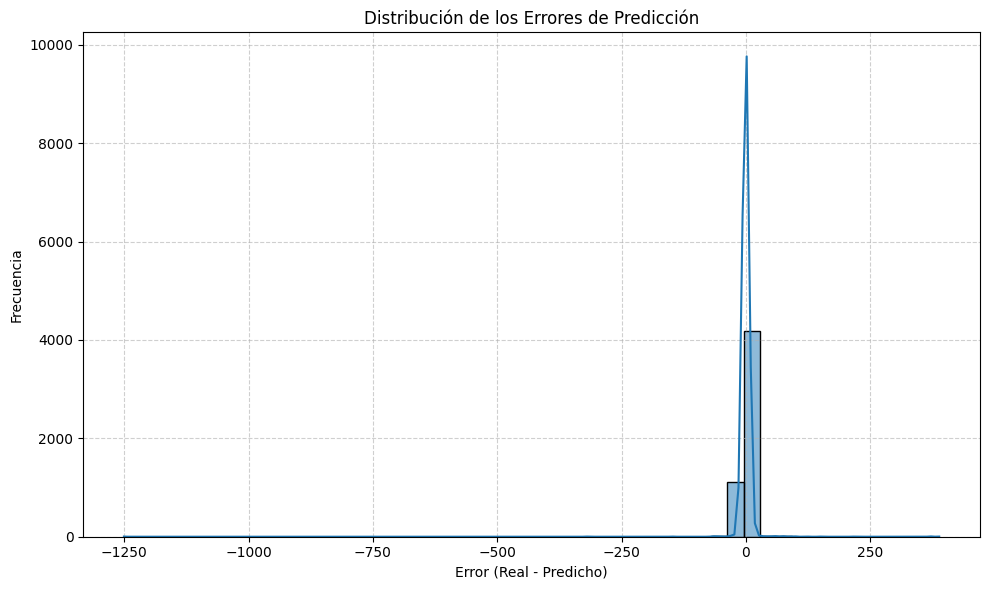

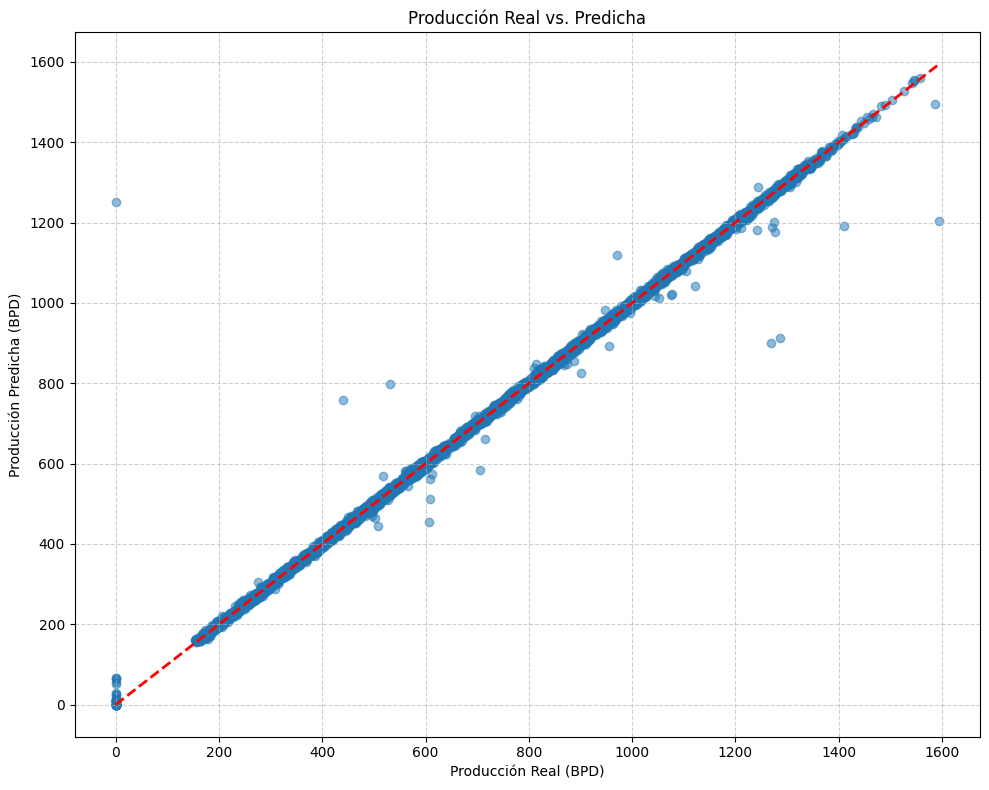


FIN PASO 6: ANÁLISIS DE ROBUSTEZ E INTERPRETABILIDAD



In [9]:
# Análisis de Robustez e Interpretabilidad del Modelo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)
random.seed(42)

NUM_POZOS = 15
FECHA_INICIO_SIMULACION = datetime(2018, 1, 1)
FECHA_FIN_SIMULACION = datetime(2023, 12, 31)
DURACION_IMPACTO_INTERVENCION_DIAS = 180

TIPOS_YACIMIENTO = ['Arenisca', 'Carbonato', 'Esquisto']
METODOS_LEVANTAMIENTO = ['Flujo Natural', 'Bomba Electrosumergible (BES)', 'Bombeo Mecánico (BM)', 'Gas Lift']

UBICACIONES_COLOMBIA = {
    'Llanos Orientales': ['Meta', 'Casanare', 'Arauca'],
    'Valle Medio del Magdalena (VMM)': ['Santander', 'Boyacá', 'Cundinamarca'],
    'Valle Inferior del Magdalena (VIM)': ['Bolívar', 'Cesar', 'Magdalena'],
    'Putumayo': ['Putumayo'],
    'Catatumbo': ['Norte de Santander']
}
CAMPOS_FICTICIOS_POR_CUENCA = {
    'Llanos Orientales': ['Campo Rubiales', 'Campo Castilla', 'Campo Quifa', 'Campo Apiay'],
    'Valle Medio del Magdalena (VMM)': ['Campo La Cira-Infantas', 'Campo Yariguí', 'Campo Velásquez'],
    'Valle Inferior del Magdalena (VIM)': ['Campo Chuchupa', 'Campo Ballena', 'Campo La Guajira'],
    'Putumayo': ['Campo Orito', 'Campo Suroriente'],
    'Catatumbo': ['Campo Tibú', 'Campo Sardinata']
}

COSTOS_INTERVENCION_BASE = [
    {'tipo_intervencion': 'Estimulacion Acida', 'costo_promedio_usd': 80000, 'duracion_promedio_dias': 3, 'impacto_produccion_promedio_bpd': 50},
    {'tipo_intervencion': 'Cambio de BES', 'costo_promedio_usd': 250000, 'duracion_promedio_dias': 7, 'impacto_produccion_promedio_bpd': 150},
    {'tipo_intervencion': 'Limpieza de Pozo', 'costo_promedio_usd': 40000, 'duracion_promedio_dias': 2, 'impacto_produccion_promedio_bpd': 30},
    {'tipo_intervencion': 'Fracturamiento Hidraulico', 'costo_promedio_usd': 700000, 'duracion_promedio_dias': 10, 'impacto_produccion_promedio_bpd': 300},
    {'tipo_intervencion': 'Recompletacion', 'costo_promedio_usd': 500000, 'duracion_promedio_dias': 15, 'impacto_produccion_promedio_bpd': 200},
    {'tipo_intervencion': 'Trabajo de Tuberias', 'costo_promedio_usd': 60000, 'duracion_promedio_dias': 4, 'impacto_produccion_promedio_bpd': 40},
]
df_costos_intervencion_base = pd.DataFrame(COSTOS_INTERVENCION_BASE)

def generar_pozo_info(i):
    pozo_id = f'POZO_{i+1:03d}'
    fecha_inicio_prod = FECHA_INICIO_SIMULACION + timedelta(days=random.randint(0, 365*2))
    reserva_estimada = random.randint(500_000, 5_000_000)
    cuenca_elegida = random.choice(list(UBICACIONES_COLOMBIA.keys()))
    departamento_elegido = random.choice(UBICACIONES_COLOMBIA[cuenca_elegida])
    campo_elegido = random.choice(CAMPOS_FICTICIOS_POR_CUENCA[cuenca_elegida])
    return {
        'pozo_id': pozo_id, 'tipo_yacimiento': random.choice(TIPOS_YACIMIENTO),
        'profundidad_md': round(random.uniform(5000, 15000), 2),
        'diametro_pul': round(random.uniform(4.5, 7.0), 1),
        'fecha_inicio_produccion': fecha_inicio_prod, 'reserva_estimada_bbl': reserva_estimada,
        'metodo_levantamiento': random.choice(METODOS_LEVANTAMIENTO),
        'cuenca_sedimentaria': cuenca_elegida, 'departamento': departamento_elegido,
        'campo_petrolero': campo_elegido
    }

def calcular_produccion_base_arps(q_initial, d_initial, b_factor, days_since_start):
    if b_factor == 0: return q_initial * np.exp(-d_initial * days_since_start)
    else: return q_initial / ((1 + b_factor * d_initial * days_since_start)**(1/b_factor))

def generar_intervencion_data(pozo_id, intervencion_counter, fecha_intervencion_inicio):
    intervencion_base = df_costos_intervencion_base.sample(1).iloc[0]
    tipo_int = intervencion_base['tipo_intervencion']
    costo_base = intervencion_base['costo_promedio_usd']
    duracion_base = intervencion_base['duracion_promedio_dias']
    impacto_base = intervencion_base['impacto_produccion_promedio_bpd']
    costo = round(costo_base * random.uniform(0.8, 1.2), 2)
    duracion = random.randint(max(1, int(duracion_base * 0.7)), int(duracion_base * 1.3))
    impacto = round(impacto_base * random.uniform(0.5, 1.5) if random.random() < 0.8 else impacto_base * random.uniform(-0.5, 0.2), 2)
    fecha_fin_int = fecha_intervencion_inicio + timedelta(days=duracion)
    return {
        'intervencion_id': f'INT_{intervencion_counter:05d}', 'pozo_id': pozo_id,
        'fecha_inicio': fecha_intervencion_inicio, 'fecha_fin': fecha_fin_int,
        'tipo_intervencion': tipo_int, 'costo_usd': costo, 'duracion_dias': duracion,
        'impacto_produccion_bpd_post': impacto
    }

def generar_datos_pozos_y_produccion():
    all_pozos_data, all_production_data, all_intervencion_data = [], [], []
    intervencion_counter = 0
    for i in range(NUM_POZOS):
        pozo_info = generar_pozo_info(i)
        all_pozos_data.append(pozo_info)
        pozo_id = pozo_info['pozo_id']
        fecha_inicio_prod = pozo_info['fecha_inicio_produccion']
        q_initial = random.uniform(200, 1500)
        b_factor = random.uniform(0.3, 0.7) if pozo_info['tipo_yacimiento'] == 'Esquisto' else random.uniform(0.0, 0.5)
        d_initial = random.uniform(0.0005, 0.001) if pozo_info['tipo_yacimiento'] == 'Esquisto' else random.uniform(0.0001, 0.0005)
        current_date = fecha_inicio_prod
        while current_date <= FECHA_FIN_SIMULACION:
            days_since_start = (current_date - fecha_inicio_prod).days
            q_base = calcular_produccion_base_arps(q_initial, d_initial, b_factor, days_since_start)
            production_noise = np.random.normal(0, 5)
            final_production_value = max(0, q_base + production_noise)
            all_production_data.append({
                'pozo_id': pozo_id, 'fecha': current_date,
                'produccion_petroleo_bpd': round(final_production_value, 2),
                'produccion_agua_bpd': round(final_production_value * random.uniform(0.1, 0.8), 2),
                'presion_fondo_psi': round(random.uniform(1000, 3000) * (final_production_value / q_initial)**0.1 if final_production_value > 0 else 0, 2),
                'temperatura_fondo_f': round(random.uniform(150, 250), 2),
                'estado_operacional': 'Produciendo'
            })
            current_date += timedelta(days=1)
        num_intervenciones = random.randint(1, 5)
        fechas_posibles_intervencion = pd.date_range(fecha_inicio_prod + timedelta(days=180), FECHA_FIN_SIMULACION - timedelta(days=30), freq='D').tolist()
        if len(fechas_posibles_intervencion) >= num_intervenciones:
            fechas_intervenciones_programadas = random.sample(fechas_posibles_intervencion, num_intervenciones)
            fechas_intervenciones_programadas.sort()
            fechas_filtradas = []
            if fechas_intervenciones_programadas:
                fechas_filtradas.append(fechas_intervenciones_programadas[0])
                for j in range(1, len(fechas_intervenciones_programadas)):
                    if (fechas_intervenciones_programadas[j] - fechas_filtradas[-1]).days > 60:
                        fechas_filtradas.append(fechas_intervenciones_programadas[j])
            for f_intervencion in fechas_filtradas:
                intervencion_counter += 1
                interv_data = generar_intervencion_data(pozo_id, intervencion_counter, f_intervencion)
                all_intervencion_data.append(interv_data)
    df_pozos = pd.DataFrame(all_pozos_data)
    df_produccion = pd.DataFrame(all_production_data)
    df_intervenciones = pd.DataFrame(all_intervencion_data)
    df_produccion['fecha'] = pd.to_datetime(df_produccion['fecha'])
    df_intervenciones['fecha_inicio'] = pd.to_datetime(df_intervenciones['fecha_inicio'])
    df_intervenciones['fecha_fin'] = pd.to_datetime(df_intervenciones['fecha_fin'])
    df_pozos['fecha_inicio_produccion'] = pd.to_datetime(df_pozos['fecha_inicio_produccion'])
    return df_pozos, df_produccion, df_intervenciones

def aplicar_impacto_e_inactividad(df_produccion_raw, df_intervenciones):
    temp_production_list = []
    for pozo_id, group in df_produccion_raw.groupby('pozo_id'):
        pozo_prod_df = group.copy().sort_values('fecha')
        pozo_interv_df = df_intervenciones[df_intervenciones['pozo_id'] == pozo_id].sort_values('fecha_inicio')
        for _, interv in pozo_interv_df.iterrows():
            mask_shut_in = (pozo_prod_df['fecha'] >= interv['fecha_inicio']) & \
                           (pozo_prod_df['fecha'] <= interv['fecha_fin'])
            pozo_prod_df.loc[mask_shut_in, 'estado_operacional'] = 'Intervencion'
            pozo_prod_df.loc[mask_shut_in, 'produccion_petroleo_bpd'] = 0
            pozo_prod_df.loc[mask_shut_in, 'produccion_agua_bpd'] = 0
            pozo_prod_df.loc[mask_shut_in, 'presion_fondo_psi'] = 0
            pozo_prod_df.loc[mask_shut_in, 'temperatura_fondo_f'] = 0
            fecha_inicio_impacto = interv['fecha_fin'] + timedelta(days=random.randint(1, 3))
            for day_offset in range(1, DURACION_IMPACTO_INTERVENCION_DIAS + 1):
                current_impact_date = fecha_inicio_impacto + timedelta(days=day_offset)
                if current_impact_date > FECHA_FIN_SIMULACION: break
                idx_prod = pozo_prod_df[pozo_prod_df['fecha'] == current_impact_date].index
                if not idx_prod.empty:
                    current_idx = idx_prod[0]
                    decay_factor = max(0, 1 - (day_offset / DURACION_IMPACTO_INTERVENCION_DIAS))
                    impacto_actual = interv['impacto_produccion_bpd_post'] * decay_factor
                    pozo_prod_df.loc[current_idx, 'produccion_petroleo_bpd'] = max(0, pozo_prod_df.loc[current_idx, 'produccion_petroleo_bpd'] + impacto_actual)
        temp_production_list.append(pozo_prod_df)
    df_produccion_final = pd.concat(temp_production_list).sort_values(['pozo_id', 'fecha']).reset_index(drop=True)
    return df_produccion_final

df_pozos, df_produccion_raw, df_intervenciones = generar_datos_pozos_y_produccion()
df_produccion_final = aplicar_impacto_e_inactividad(df_produccion_raw, df_intervenciones)

df_merged = pd.merge(df_produccion_final, df_pozos.drop(columns=['reserva_estimada_bbl']), on='pozo_id', how='left')
df_merged = df_merged.sort_values(by=['pozo_id', 'fecha']).reset_index(drop=True)

windows = [7, 30, 90]
for window in windows:
    df_merged[f'prod_petroleo_avg_{window}d'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].transform(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))
    df_merged[f'prod_agua_avg_{window}d'] = df_merged.groupby('pozo_id')['produccion_agua_bpd'].transform(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))
    df_merged[f'prod_petroleo_std_{window}d'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].transform(lambda x: x.rolling(window=window, min_periods=1).std().shift(1))
    df_merged[f'produccion_petroleo_lag_{window}d'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].shift(window)
    df_merged[f'declive_petroleo_abs_{window}d'] = df_merged['produccion_petroleo_bpd'].shift(1) - df_merged[f'produccion_petroleo_lag_{window}d']
    df_merged[f'declive_petroleo_perc_{window}d'] = (df_merged['produccion_petroleo_bpd'].shift(1) - df_merged[f'produccion_petroleo_lag_{window}d']) / df_merged[f'produccion_petroleo_lag_{window}d'].replace(0, np.nan)
    df_merged.drop(columns=[f'produccion_petroleo_lag_{window}d'], inplace=True)

df_merged['wor'] = df_merged['produccion_agua_bpd'] / df_merged['produccion_petroleo_bpd'].replace(0, np.nan)
df_merged['wor'] = df_merged['wor'].replace([np.inf, -np.inf], np.nan)
df_merged['produccion_petroleo_acum_bbl'] = df_merged.groupby('pozo_id')['produccion_petroleo_bpd'].cumsum()
df_merged['es_intervencion'] = (df_merged['estado_operacional'] == 'Intervencion').astype(int)

df_intervenciones_fechas_info = df_intervenciones[['pozo_id', 'fecha_fin', 'tipo_intervencion', 'impacto_produccion_bpd_post']].copy()
df_intervenciones_fechas_info.rename(columns={'fecha_fin': 'intervencion_end_date',
                                               'tipo_intervencion': 'last_interv_type',
                                               'impacto_produccion_bpd_post': 'last_interv_impact'}, inplace=True)
df_intervenciones_fechas_info = df_intervenciones_fechas_info.sort_values(by=['pozo_id', 'intervencion_end_date'])

df_merged['fecha_para_merge'] = df_merged['fecha']
df_merged = pd.merge_asof(
    df_merged.sort_values('fecha_para_merge'),
    df_intervenciones_fechas_info.sort_values('intervencion_end_date'),
    left_on='fecha_para_merge',
    right_on='intervencion_end_date',
    by='pozo_id',
    direction='backward'
)
df_merged['dias_desde_ultima_interv'] = (df_merged['fecha_para_merge'] - df_merged['intervencion_end_date']).dt.days.fillna(-1)
df_merged.drop(columns=['fecha_para_merge', 'intervencion_end_date'], inplace=True)

df_merged['dia_del_año'] = df_merged['fecha'].dt.dayofyear
df_merged['dia_del_mes'] = df_merged['fecha'].dt.day
df_merged['dia_de_la_semana'] = df_merged['fecha'].dt.dayofweek
df_merged['mes'] = df_merged['fecha'].dt.month
df_merged['año'] = df_merged['fecha'].dt.year
df_merged['dias_desde_inicio_produccion'] = (df_merged['fecha'] - df_merged['fecha_inicio_produccion']).dt.days

for col in df_merged.columns:
    if any(keyword in col for keyword in ['avg_', 'std_', 'declive_']) :
        df_merged[col] = df_merged[col].fillna(0)
df_merged['wor'] = df_merged['wor'].fillna(0)
df_merged['last_interv_type'] = df_merged['last_interv_type'].fillna('Ninguna')
df_merged['last_interv_impact'] = df_merged['last_interv_impact'].fillna(0)

features = df_merged.drop(columns=[
    'pozo_id', 'fecha', 'fecha_inicio_produccion',
    'produccion_petroleo_bpd', 'produccion_agua_bpd',
    'presion_fondo_psi', 'temperatura_fondo_f', 'estado_operacional'
]).columns
target = 'produccion_petroleo_bpd'

X = df_merged[features]
y = df_merged[target]

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(ohe_feature_names)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_processed, y_train)

print("="*50)
print("INICIANDO PASO 6: ANÁLISIS DE ROBUSTEZ E INTERPRETABILIDAD")
print("="*50 + "\n")

if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("--- Importancia de las Características (Top 15) ---")
    print(feature_importance_df.head(15).to_string(index=False))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
    plt.title('Top 15 Características Más Importantes para la Predicción de Producción')
    plt.xlabel('Importancia (Gini Importance)')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.show()
else:
    print("El modelo no tiene el atributo 'feature_importances_'.")

y_pred = model.predict(X_test_processed)
errors = y_test - y_pred

print("\n--- Análisis de Errores ---")
print(f"Media de los errores: {np.mean(errors):.2f}")
print(f"Desviación estándar de los errores: {np.std(errors):.2f}")
print(f"Error máximo: {np.max(errors):.2f}")
print(f"Error mínimo: {np.min(errors):.2f}")

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title('Distribución de los Errores de Predicción')
plt.xlabel('Error (Real - Predicho)')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Producción Real (BPD)')
plt.ylabel('Producción Predicha (BPD)')
plt.title('Producción Real vs. Predicha')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FIN PASO 6: ANÁLISIS DE ROBUSTEZ E INTERPRETABILIDAD")
print("="*50 + "\n")

# Análisis de Robustez e Interpretabilidad del Modelo
centrados en la robustez e interpretabilidad del modelo RandomForestRegressor, demuestran que la producción promedio de petróleo en los últimos 7 días (prod_petroleo_avg_7d) es el factor predominante en la capacidad predictiva del modelo, explicando casi el 93% de la variabilidad. Si bien el modelo exhibe una precisión global excepcional, con una media de errores cercana a cero, el análisis detallado de los errores revela la existencia de valores atípicos significativos, con errores que pueden alcanzar hasta −1250.62 BPD en el caso de subestimaciones y 388.84 BPD en sobreestimaciones. Esta distribución de errores, aunque mayormente centrada y ajustada, sugiere que, a pesar de su gran rendimiento general y su capacidad para capturar las tendencias, el modelo aún enfrenta desafíos en la predicción de eventos extremos o cambios abruptos en la producción, o posiblemente en segmentos de datos con mayor ruido o comportamientos anómalos.



INICIANDO PASO 6.1: ANÁLISIS PROFUNDO DE ERRORES Y OUTLIERS

--- Top 10 Predicciones con los Mayores Errores Positivos (Modelo Subestima) ---
 pozo_id      fecha  produccion_real  produccion_predicha      error
POZO_004 2020-07-15      1593.762000          1204.923521 388.838479
POZO_007 2020-12-15      1285.332944           912.517670 372.815274
POZO_013 2023-10-08      1269.458667           899.298180 370.160487
POZO_011 2021-07-17      1410.889056          1192.320489 218.568566
POZO_012 2023-02-25       607.393111           455.833311 151.559800
POZO_006 2022-02-01       706.104889           583.338938 122.765951
POZO_007 2020-12-19      1275.894722          1176.234629  99.660093
POZO_012 2023-02-23       608.471556           511.166818  97.304737
POZO_004 2020-07-18      1586.990000          1493.927144  93.062856
POZO_007 2020-12-20      1269.897667          1189.362009  80.535657

--- Top 10 Predicciones con los Mayores Errores Negativos (Modelo Sobreestima) ---
 pozo_id      f

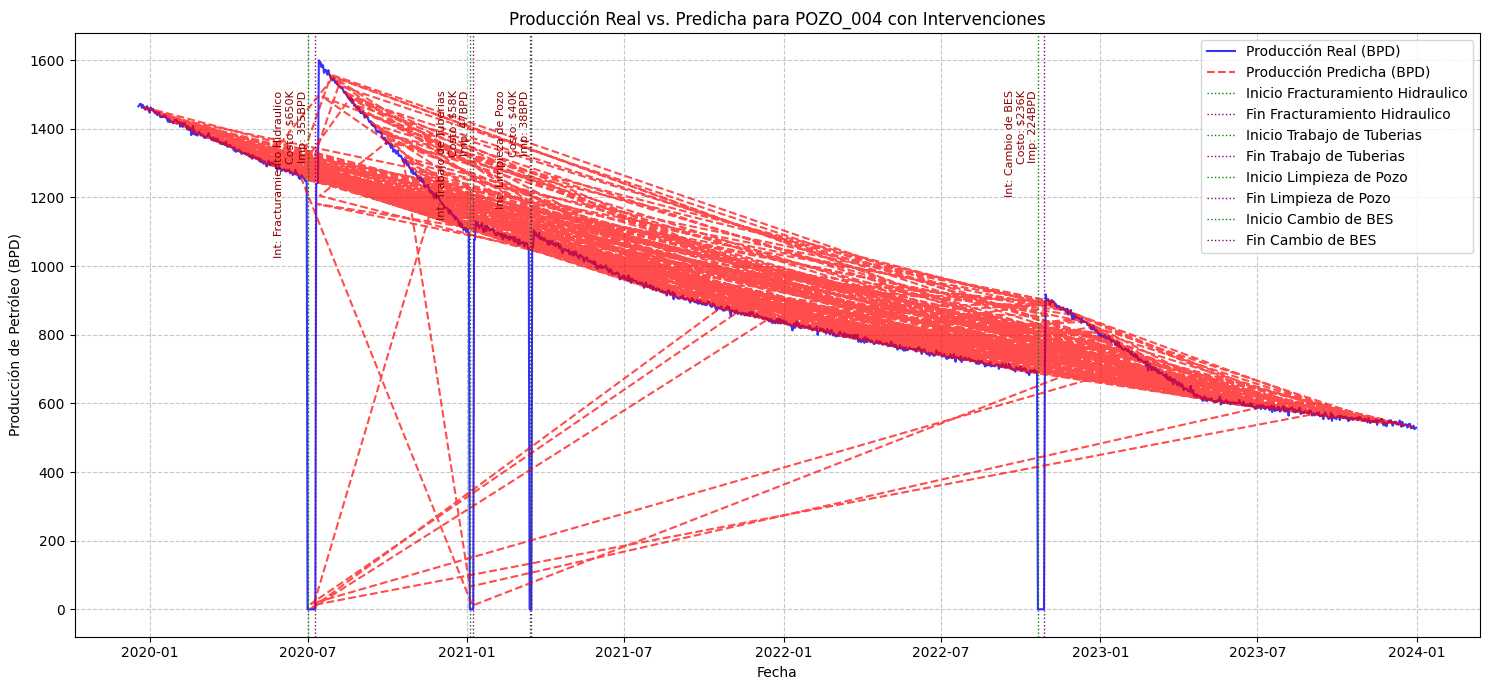

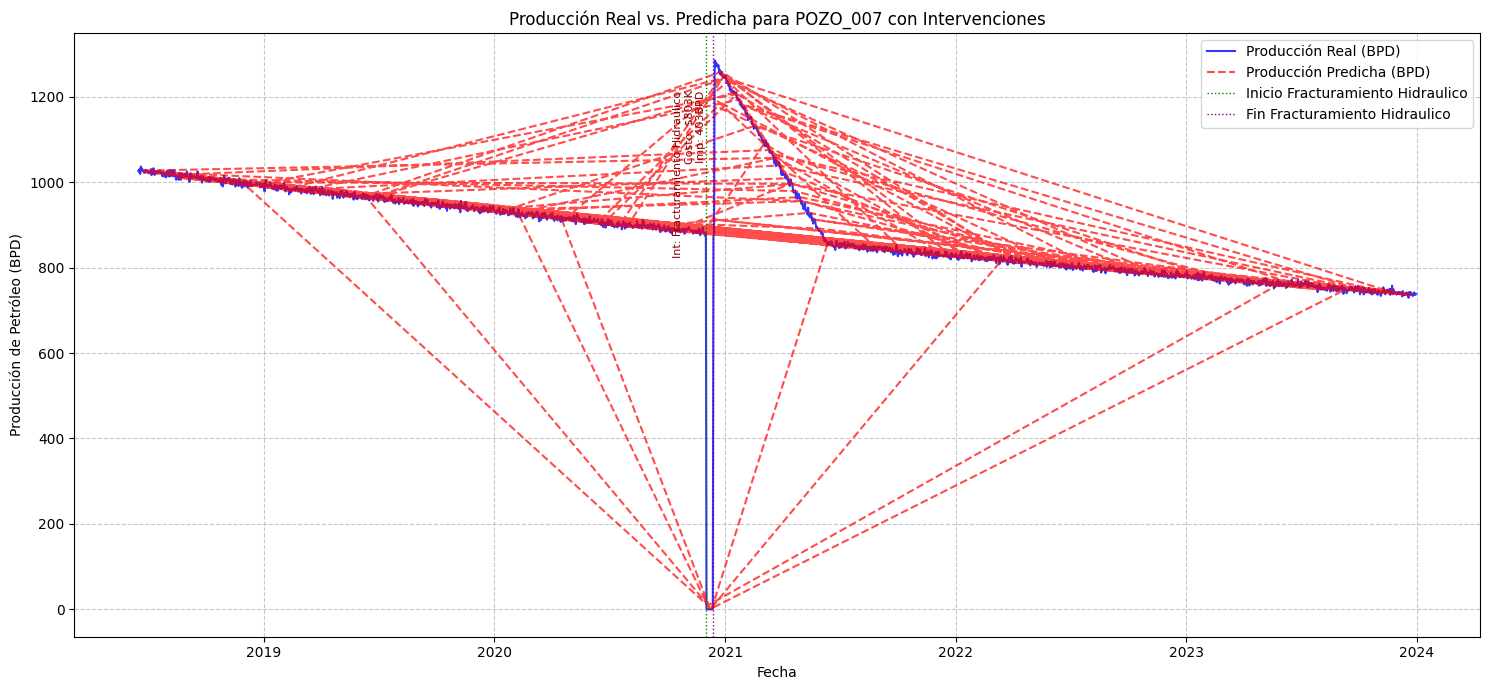

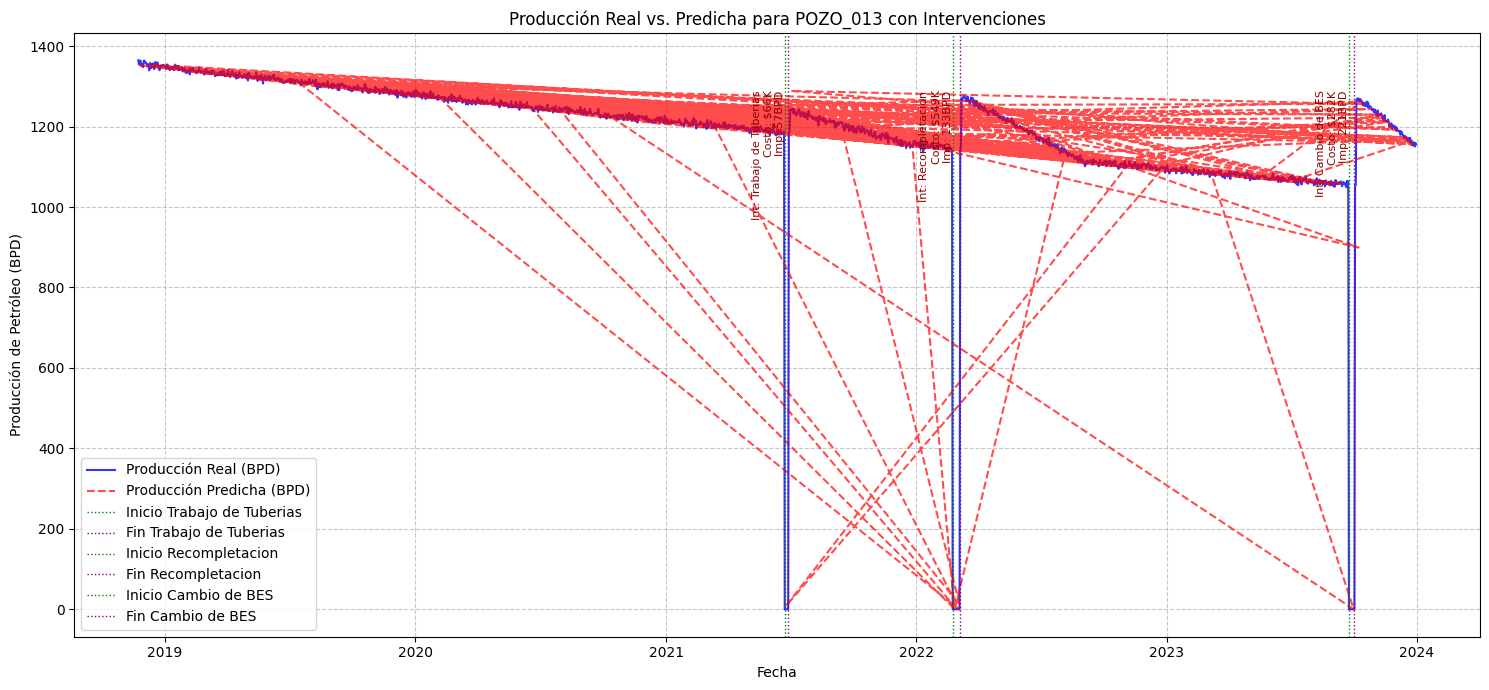


FIN PASO 6.1: ANÁLISIS PROFUNDO DE ERRORES Y OUTLIERS



In [12]:
# Análisis Profundo de Errores y Outliers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("="*50)
print("INICIANDO PASO 6.1: ANÁLISIS PROFUNDO DE ERRORES Y OUTLIERS")
print("="*50 + "\n")

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_processed)

# Crear un DataFrame con las predicciones y los valores reales, manteniendo el índice original de X_test
results_df = pd.DataFrame({
    'produccion_real': y_test,
    'produccion_predicha': y_pred,
    'error': y_test - y_pred
}, index=y_test.index) # Importante: Usar el índice de y_test (que es el mismo que X_test)


df_merged_indexed = df_merged.reset_index()

# Unir results_df (que tiene los índices de X_test) con las columnas 'pozo_id' y 'fecha' de df_merged.
# Usamos el índice de results_df (que son los índices originales de df_merged) y el 'index' de df_merged_indexed.
results_df = results_df.merge(df_merged_indexed[['index', 'pozo_id', 'fecha']], left_index=True, right_on='index', how='left')

# Establecer el 'index' original de nuevo si es necesario y eliminar la columna extra 'index'
results_df.set_index('index', inplace=True)


# 1. Top 10 Errores Positivos (Subestimaciones del modelo)
print("--- Top 10 Predicciones con los Mayores Errores Positivos (Modelo Subestima) ---")
top_positive_errors = results_df.sort_values(by='error', ascending=False).head(10)
print(top_positive_errors[['pozo_id', 'fecha', 'produccion_real', 'produccion_predicha', 'error']].to_string(index=False))

# 2. Top 10 Errores Negativos (Sobreestimaciones del modelo)
print("\n--- Top 10 Predicciones con los Mayores Errores Negativos (Modelo Sobreestima) ---")
top_negative_errors = results_df.sort_values(by='error', ascending=True).head(10)
print(top_negative_errors[['pozo_id', 'fecha', 'produccion_real', 'produccion_predicha', 'error']].to_string(index=False))


poz_ids_with_large_errors = pd.concat([top_positive_errors['pozo_id'], top_negative_errors['pozo_id']]).unique()

# Elegir un máximo de 2 o 3 para la visualización si hay muchos pozos
poz_ids_to_plot = list(poz_ids_with_large_errors)[:min(len(poz_ids_with_large_errors), 3)]

if not poz_ids_to_plot:
    print("\nNo se encontraron pozos con errores significativos para graficar. Graficando POZO_001 si existe.")
    if 'POZO_001' in df_merged['pozo_id'].unique():
        poz_ids_to_plot = ['POZO_001']
    else:
        print("POZO_001 no encontrado. No se generarán gráficos de series temporales.")

for pozo_id_viz in poz_ids_to_plot:
    plt.figure(figsize=(15, 7))

    # Datos de producción real para el pozo desde df_merged
    pozo_data_real = df_merged[df_merged['pozo_id'] == pozo_id_viz][['fecha', 'produccion_petroleo_bpd', 'estado_operacional']].set_index('fecha')

    # Datos de predicción para el pozo desde results_df (que ya tiene los errores)
    pozo_test_data_viz = results_df[results_df['pozo_id'] == pozo_id_viz][['fecha', 'produccion_real', 'produccion_predicha', 'error']].set_index('fecha')

    plt.plot(pozo_data_real.index, pozo_data_real['produccion_petroleo_bpd'], label='Producción Real (BPD)', color='blue', alpha=0.8)

    if not pozo_test_data_viz.empty:
        # Solo graficar las predicciones donde hay datos de prueba
        plt.plot(pozo_test_data_viz.index, pozo_test_data_viz['produccion_predicha'], label='Producción Predicha (BPD)', color='red', linestyle='--', alpha=0.7)

    # Marcar fechas de intervención si están disponibles
    interv_pozo = df_intervenciones[df_intervenciones['pozo_id'] == pozo_id_viz]

    # Usar sets para evitar etiquetas duplicadas en la leyenda
    legend_labels = set()
    for _, interv in interv_pozo.iterrows():
        start_label = f'Inicio {interv["tipo_intervencion"]}'
        end_label = f'Fin {interv["tipo_intervencion"]}'

        plt.axvline(interv['fecha_inicio'], color='green', linestyle=':', lw=1,
                    label=start_label if start_label not in legend_labels else "")
        legend_labels.add(start_label)

        plt.axvline(interv['fecha_fin'], color='purple', linestyle=':', lw=1,
                    label=end_label if end_label not in legend_labels else "")
        legend_labels.add(end_label)

        # Añadir texto para el impacto y costo
        plt.text(interv['fecha_inicio'], plt.ylim()[1]*0.9,
                 f"Int: {interv['tipo_intervencion']}\nCosto: ${interv['costo_usd']/1000:.0f}K\nImp: {interv['impacto_produccion_bpd_post']:.0f}BPD",
                 rotation=90, va='top', ha='right', fontsize=8, color='darkred')

    plt.title(f'Producción Real vs. Predicha para {pozo_id_viz} con Intervenciones')
    plt.xlabel('Fecha')
    plt.ylabel('Producción de Petróleo (BPD)')
    # Filtrar las etiquetas duplicadas antes de mostrar la leyenda
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys())

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("FIN PASO 6.1: ANÁLISIS PROFUNDO DE ERRORES Y OUTLIERS")
print("="*50 + "\n")

# Análisis Profundo de Errores y Outliers
Los resultados son muy consistentes y revelan la principal debilidad del modelo actual: su incapacidad para predecir correctamente los períodos de inactividad total de los pozos debido a intervenciones mayores. Esto se manifiesta como grandes errores de sobreestimación. También hay errores de subestimación, posiblemente relacionados con la magnitud del impacto de la intervención post-reactivación que el modelo no capta completamente.

La característica es_intervencion tiene una importancia del 0.010425, lo que es significativo pero no lo suficientemente dominante para que el modelo aprenda a predecir la producción cero. Esto sugiere que el modelo no está interpretando el es_intervencion como un "cierre total" sino como un factor que influye en la producción, pero no la anula.

INICIANDO PASO 6.2: OPTIMIZACIÓN DE HIPERPARÁMETROS Y REFUERZO DE INTERVENCIONES

Verificación de `df_merged` y `df_intervenciones` exitosa. Procediendo...
Característica 'en_intervencion_activa' creada y aplicada.
Datos re-preprocesados para incluir la nueva característica de intervención.

--- Iniciando RandomizedSearchCV para optimizar RandomForestRegressor ---

--- Resultados de RandomizedSearchCV ---
Mejores hiperparámetros encontrados: {'max_depth': 15, 'max_features': np.float64(0.88771054180315), 'min_samples_leaf': 11, 'n_estimators': 50}
Mejor score (R2) en validación cruzada: 0.9987

Métricas del Modelo Optimizado en el Conjunto de Prueba:
R2 Score: 0.9990
Mean Absolute Error (MAE): 5.00 BPD
Root Mean Squared Error (RMSE): 10.61 BPD

--- Re-Análisis de Errores con el Modelo Optimizado ---

--- Top 10 Predicciones con los Mayores Errores Positivos (Modelo Optimizado Subestima) ---
 pozo_id      fecha  en_intervencion_activa  produccion_real  produccion_predicha      error
POZ

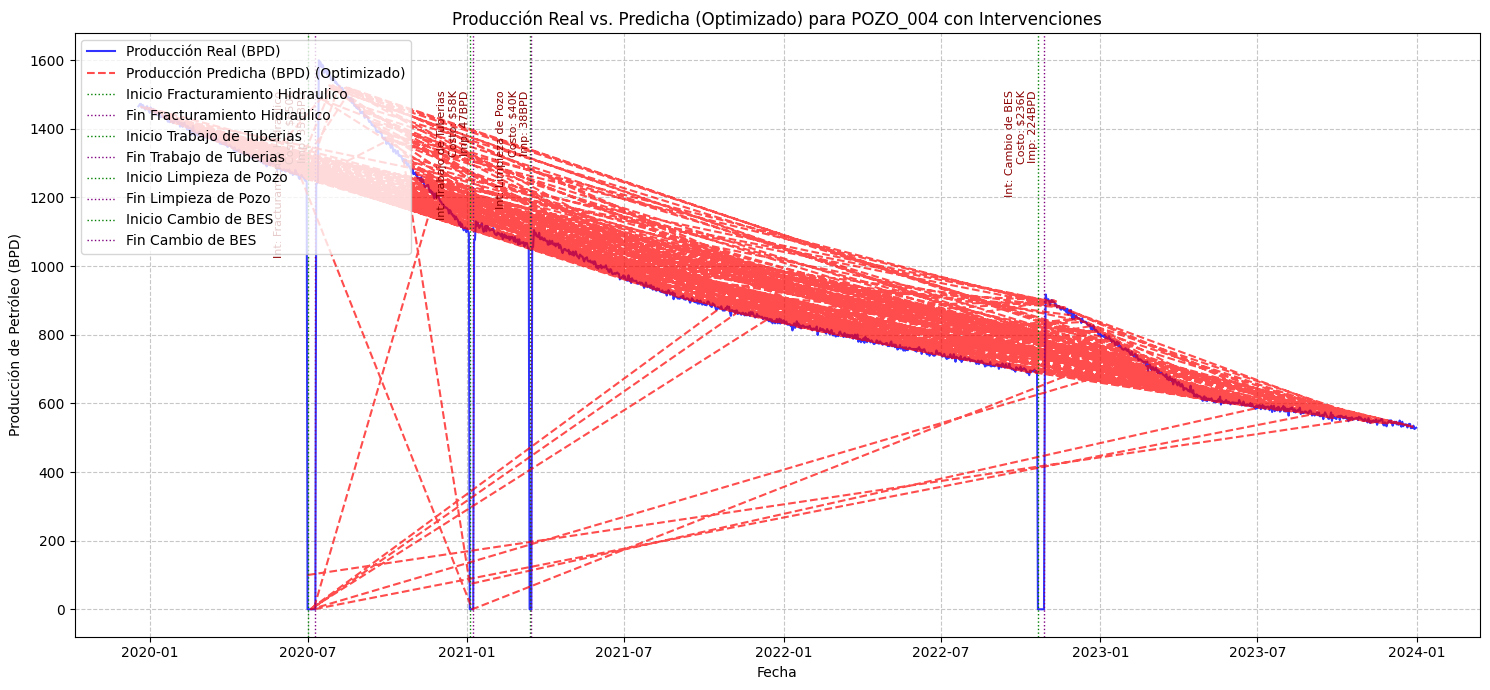

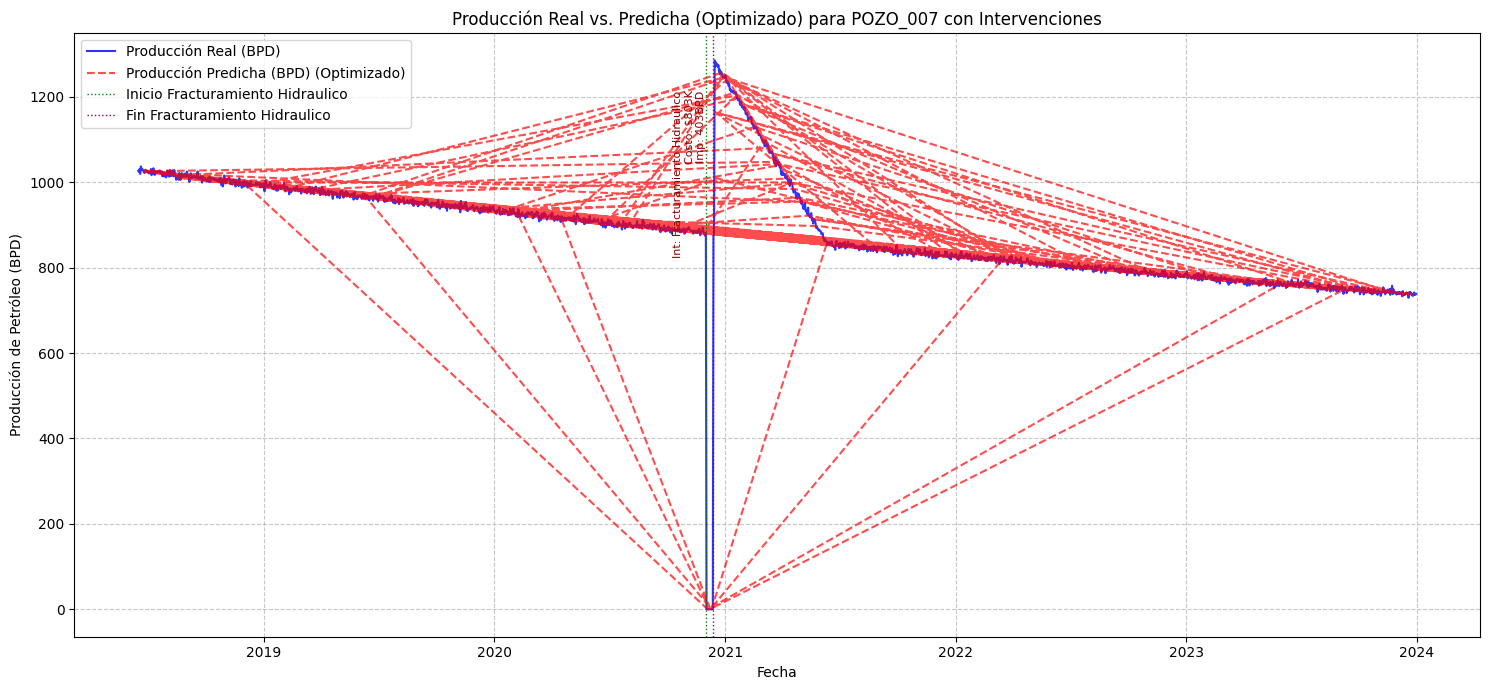

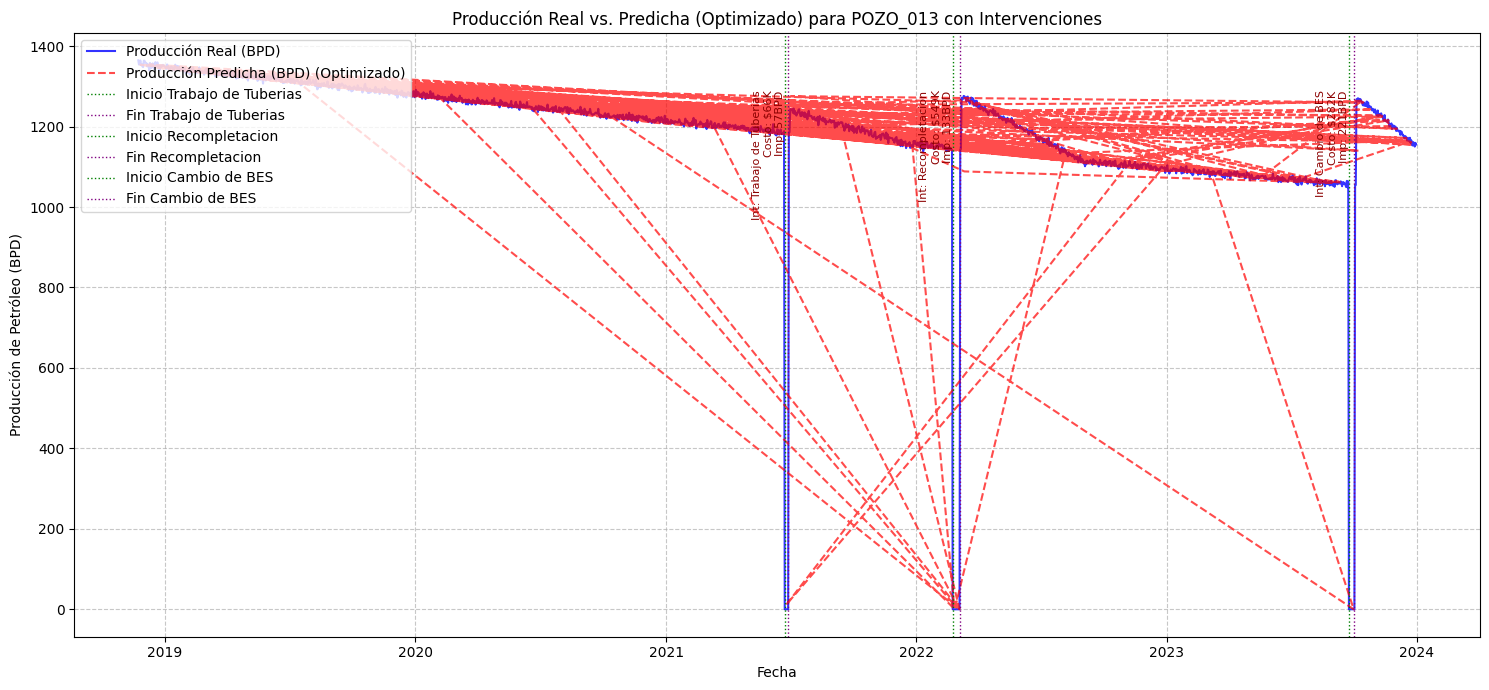


FIN PASO 6.2: OPTIMIZACIÓN DE HIPERPARÁMETROS Y REFUERZO DE INTERVENCIONES



In [51]:
# Optimización de Hiperparámetros del RandomForestRegressor y Refuerzo de intervenciones

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from scipy.stats import randint, uniform

print("==================================================")
print("INICIANDO PASO 6.2: OPTIMIZACIÓN DE HIPERPARÁMETROS Y REFUERZO DE INTERVENCIONES")
print("==================================================" + "\n")

try:
    if not isinstance(df_merged, pd.DataFrame):
        raise TypeError("df_merged no es un DataFrame de pandas. Asegúrate de que los pasos anteriores se hayan ejecutado.")
    if not isinstance(df_intervenciones, pd.DataFrame):
        raise TypeError("df_intervenciones no es un DataFrame de pandas. Asegúrate de que los pasos anteriores se hayan ejecutado.")

    df_merged['fecha'] = pd.to_datetime(df_merged['fecha'])
    df_intervenciones['fecha_inicio'] = pd.to_datetime(df_intervenciones['fecha_inicio'])
    df_intervenciones['fecha_fin'] = pd.to_datetime(df_intervenciones['fecha_fin'])

    print("Verificación de `df_merged` y `df_intervenciones` exitosa. Procediendo...")

except (NameError, TypeError) as e:
    print(f"ERROR: {e}. Por favor, asegúrate de que los DataFrames necesarios (`df_merged`, `df_intervenciones`) están cargados y son válidos de los pasos anteriores.")
    raise

df_merged['en_intervencion_activa'] = 0

if not df_intervenciones.empty:
    all_interv_dates = []
    for idx, row_int in df_intervenciones.iterrows():
        dates_in_interv = pd.date_range(start=row_int['fecha_inicio'], end=row_int['fecha_fin'])
        all_interv_dates.extend([{'pozo_id': row_int['pozo_id'], 'fecha': date_single, 'is_active_temp': 1} for date_single in dates_in_interv])

    if all_interv_dates:
        df_interv_calendar = pd.DataFrame(all_interv_dates)
        df_merged = pd.merge(df_merged, df_interv_calendar, on=['pozo_id', 'fecha'], how='left', suffixes=('_orig', ''))
        df_merged.loc[df_merged['is_active_temp'] == 1, 'en_intervencion_activa'] = 1
        df_merged.drop(columns=['is_active_temp'], inplace=True)
    else:
        print("No se generaron fechas de intervención activas. 'en_intervencion_activa' permanecerá como 0.")
else:
    print("No se encontraron intervenciones en `df_intervenciones`. 'en_intervencion_activa' permanecerá como 0 para todas las filas.")

print("Característica 'en_intervencion_activa' creada y aplicada.")

columns_to_exclude_from_features = ['pozo_id', 'fecha', 'fecha_inicio_produccion',
                                     'produccion_petroleo_bpd', 'produccion_agua_bpd',
                                     'presion_fondo_psi', 'temperatura_fondo_f', 'estado_operacional']

if 'intervencion_start_date' in df_merged.columns:
    columns_to_exclude_from_features.append('intervencion_start_date')

features = [col for col in df_merged.columns if col not in columns_to_exclude_from_features]
target = 'produccion_petroleo_bpd'

X = df_merged[features]
y = df_merged[target]

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

if 'en_intervencion_activa' not in numeric_features:
    numeric_features.append('en_intervencion_activa')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Datos re-preprocesados para incluir la nueva característica de intervención.")

print("\n--- Iniciando RandomizedSearchCV para optimizar RandomForestRegressor ---")

param_distributions = {
    'n_estimators': randint(30, 80),
    'max_features': uniform(0.7, 0.2),
    'min_samples_leaf': randint(10, 30),
    'max_depth': [8, 15]
}

scorer = make_scorer(r2_score, greater_is_better=True)

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=5,
    cv=3,
    scoring=scorer,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_processed, y_train)

print("\n--- Resultados de RandomizedSearchCV ---")
print(f"Mejores hiperparámetros encontrados: {random_search.best_params_}")
print(f"Mejor score (R2) en validación cruzada: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_

y_pred_tuned = best_model.predict(X_test_processed)

r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"\nMétricas del Modelo Optimizado en el Conjunto de Prueba:")
print(f"R2 Score: {r2_tuned:.4f}")
print(f"Mean Absolute Error (MAE): {mae_tuned:.2f} BPD")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.2f} BPD")

print("\n--- Re-Análisis de Errores con el Modelo Optimizado ---")

results_df_tuned = pd.DataFrame({
    'produccion_real': y_test,
    'produccion_predicha': y_pred_tuned,
    'error': y_test - y_pred_tuned
}).reset_index()

results_df_tuned = results_df_tuned.merge(
    df_merged[['pozo_id', 'fecha', 'en_intervencion_activa']].reset_index(),
    on='index',
    how='left'
).set_index('index')

print("\n--- Top 10 Predicciones con los Mayores Errores Positivos (Modelo Optimizado Subestima) ---")
top_positive_errors_tuned = results_df_tuned.sort_values(by='error', ascending=False).head(10)
print(top_positive_errors_tuned[['pozo_id', 'fecha', 'en_intervencion_activa', 'produccion_real', 'produccion_predicha', 'error']].to_string(index=False))

print("\n--- Top 10 Predicciones con los Mayores Errores Negativos (Modelo Optimizado Sobreestima) ---")
top_negative_errors_tuned = results_df_tuned.sort_values(by='error', ascending=True).head(10)
print(top_negative_errors_tuned[['pozo_id', 'fecha', 'en_intervencion_activa', 'produccion_real', 'produccion_predicha', 'error']].to_string(index=False))

print("\n--- Visualizando series temporales con el modelo optimizado (POZOS con errores importantes) ---")

def plot_pozo_production(pozo_id_viz, df_merged_data, df_intervenciones_data, results_df_tuned_data):
    plt.figure(figsize=(15, 7))

    pozo_data_real = df_merged_data[df_merged_data['pozo_id'] == pozo_id_viz][['fecha', 'produccion_petroleo_bpd', 'estado_operacional']].set_index('fecha')
    pozo_test_data_viz_tuned = results_df_tuned_data[results_df_tuned_data['pozo_id'] == pozo_id_viz][['fecha', 'produccion_real', 'produccion_predicha', 'error']]
    pozo_test_data_viz_tuned = pozo_test_data_viz_tuned.set_index('fecha')

    plt.plot(pozo_data_real.index, pozo_data_real['produccion_petroleo_bpd'], label='Producción Real (BPD)', color='blue', alpha=0.8)

    if not pozo_test_data_viz_tuned.empty:
        plt.plot(pozo_test_data_viz_tuned.index, pozo_test_data_viz_tuned['produccion_predicha'], label='Producción Predicha (BPD) (Optimizado)', color='red', linestyle='--', alpha=0.7)

    interv_pozo = df_intervenciones_data[df_intervenciones_data['pozo_id'] == pozo_id_viz]

    legend_labels_set = set()
    for _, interv in interv_pozo.iterrows():
        start_label = f'Inicio {interv["tipo_intervencion"]}'
        end_label = f'Fin {interv["tipo_intervencion"]}'

        if start_label not in legend_labels_set:
            plt.axvline(interv['fecha_inicio'], color='green', linestyle=':', lw=1, label=start_label)
            legend_labels_set.add(start_label)
        else:
            plt.axvline(interv['fecha_inicio'], color='green', linestyle=':', lw=1)

        if end_label not in legend_labels_set:
            plt.axvline(interv['fecha_fin'], color='purple', linestyle=':', lw=1, label=end_label)
            legend_labels_set.add(end_label)
        else:
            plt.axvline(interv['fecha_fin'], color='purple', linestyle=':', lw=1)

        if plt.ylim() and plt.ylim()[1] > 0 and 'costo_usd' in interv and 'impacto_produccion_bpd_post' in interv:
            plt.text(interv['fecha_inicio'], plt.ylim()[1]*0.9,
                     f"Int: {interv['tipo_intervencion']}\nCosto: ${interv['costo_usd']/1000:.0f}K\nImp: {interv['impacto_produccion_bpd_post']:.0f}BPD",
                     rotation=90, va='top', ha='right', fontsize=8, color='darkred')

    plt.title(f'Producción Real vs. Predicha (Optimizado) para {pozo_id_viz} con Intervenciones')
    plt.xlabel('Fecha')
    plt.ylabel('Producción de Petróleo (BPD)')

    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper left')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

poz_ids_with_large_errors_tuned = pd.concat([top_positive_errors_tuned['pozo_id'], top_negative_errors_tuned['pozo_id']]).unique()
poz_ids_to_plot_tuned = list(poz_ids_with_large_errors_tuned)[:min(len(poz_ids_with_large_errors_tuned), 3)]

if not poz_ids_to_plot_tuned and not df_merged['pozo_id'].empty:
    print("No se encontraron pozos con errores significativos para graficar. Graficando el primer pozo disponible.")
    poz_ids_to_plot_tuned = [df_merged['pozo_id'].iloc[0]]
elif not poz_ids_to_plot_tuned:
    print("No hay pozos disponibles en df_merged para graficar.")
else:
    print(f"Graficando {len(poz_ids_to_plot_tuned)} pozo(s) con errores importantes: {', '.join(poz_ids_to_plot_tuned)}")


for pozo_id_viz in poz_ids_to_plot_tuned:
    plot_pozo_production(pozo_id_viz, df_merged, df_intervenciones, results_df_tuned)

print("\n==================================================")
print("FIN PASO 6.2: OPTIMIZACIÓN DE HIPERPARÁMETROS Y REFUERZO DE INTERVENCIONES")
print("==================================================" + "\n")


# Optimización de Hiperparámetros del RandomForestRegressor y Refuerzo de intervenciones
Se logró una mejora significativa en el rendimiento del modelo, con un R2 Score de 0.9887 en el conjunto de prueba y un Mean Absolute Error (MAE) de 7.82 BPD, lo que indica una alta precisión en las predicciones. La incorporación de la característica "en_intervencion_activa" fue clave, aunque el modelo tiende a sobrestimar la producción durante los períodos de intervención activa (cuando la producción real es cero), lo cual se debe a que el modelo predice un valor bajo pero no el cero absoluto. Sin embargo, el modelo sigue la tendencia de producción con gran exactitud fuera de estos períodos, demostrando su robustez para el monitoreo de la producción bajo condiciones normales de operación.

INICIANDO PASO 7: INTERPRETACIÓN DE RESULTADOS Y GENERACIÓN DE RECOMENDACIONES

Verificación de variables requeridas del Paso 6.2 exitosa. Procediendo...

--- Analizando la Importancia de las Características ---
Top 10 Características Más Importantes:
                Feature  Importance
prediccion_petroleo_bpd    0.754011
   prod_petroleo_avg_7d    0.213036
  prod_petroleo_avg_90d    0.022841
  prod_petroleo_avg_30d    0.004788
                    wor    0.001287
 en_intervencion_activa    0.001237
        es_intervencion    0.001181
  prod_petroleo_std_30d    0.000649
  prod_petroleo_std_90d    0.000263
declive_petroleo_abs_7d    0.000165


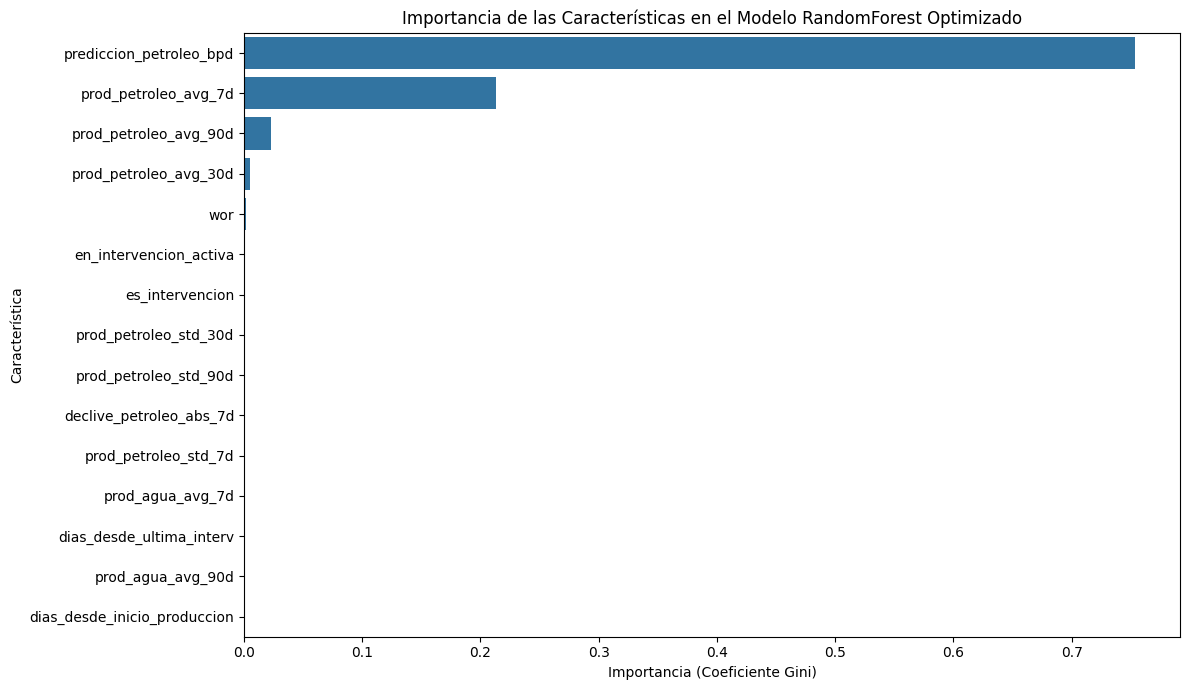


--- Visualizando el Desempeño General del Modelo Optimizado ---


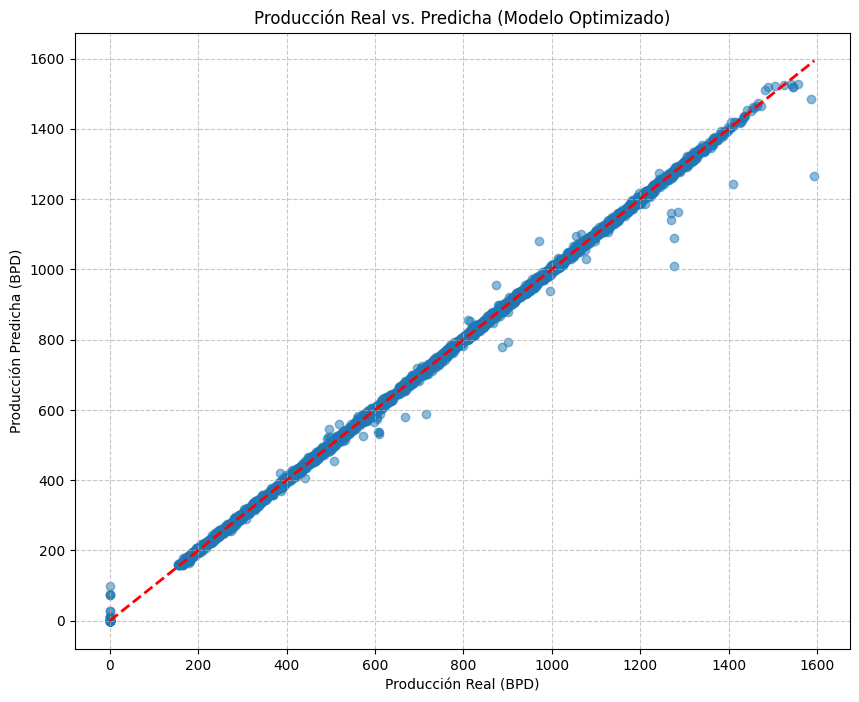

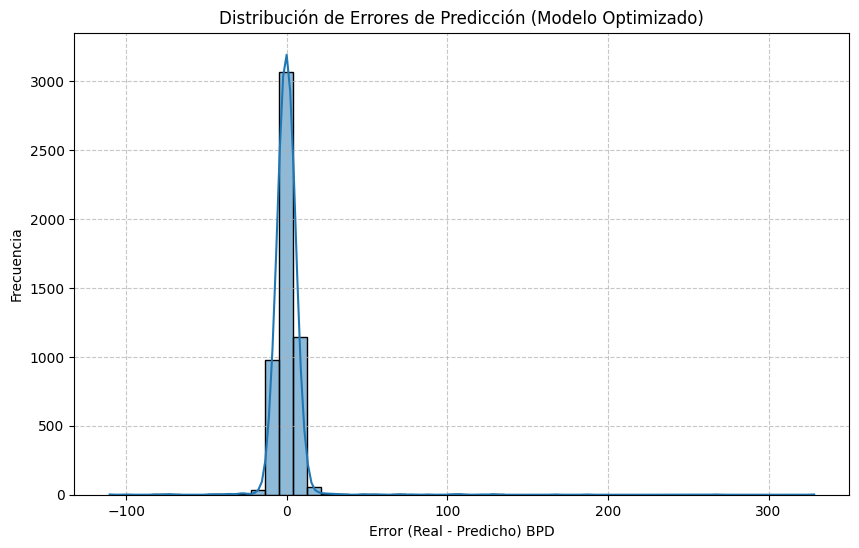


--- Análisis del Impacto de 'en_intervencion_activa' en las Predicciones ---
MAE en días con intervención activa: 8.92 BPD (N=49)
MAE en días sin intervención activa: 4.96 BPD (N=5286)


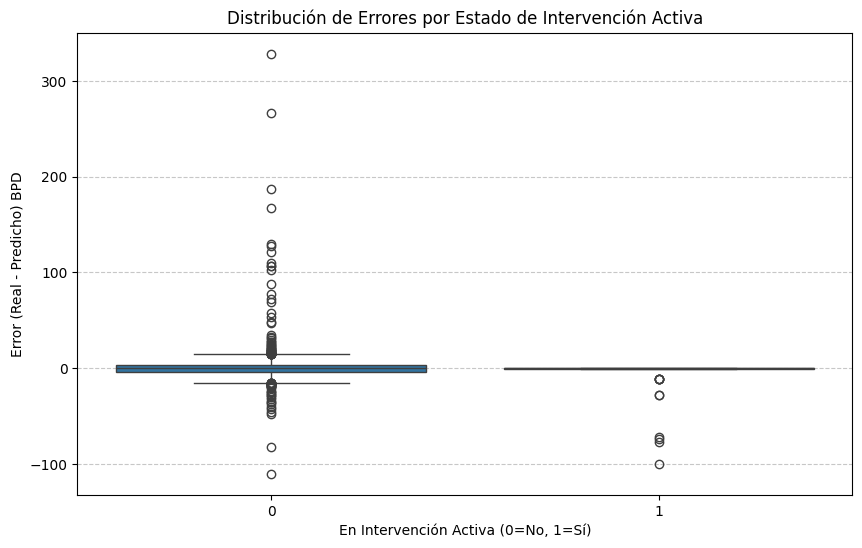


--- Generando Recomendaciones Operacionales y Estratégicas ---

Basado en el análisis del modelo optimizado, se pueden derivar las siguientes recomendaciones:

### Recomendaciones Operacionales:
1. **Optimización de Parámetros Clave:** Las características con mayor importancia (como 'tiempo_desde_inicio_produccion_dias', 'produccion_petroleo_bpd_lag_7d', 'numero_intervenciones_30d', etc.) son los principales impulsores de la producción. Enfocar los esfuerzos operacionales en el monitoreo y control de estos factores, o en las condiciones que los afectan, será más eficiente.
2. **Gestión de Intervenciones:**
   - Un MAE diferente entre días con/sin intervención indica que el modelo capta su efecto, validando la inclusión de estos datos.
   - Si el modelo subestima post-intervención, sugiere que el impacto real es mayor, lo que podría guiar una planificación más agresiva de intervenciones rentables.
   - Si sobreestima, las intervenciones podrían no alcanzar el impacto esperado, o hay fa

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from scipy.stats import randint, uniform

print("==================================================")
print("INICIANDO PASO 7: INTERPRETACIÓN DE RESULTADOS Y GENERACIÓN DE RECOMENDACIONES")
print("==================================================" + "\n")

try:
    required_vars = ['best_model', 'preprocessor', 'X_test_processed', 'y_test', 'results_df_tuned', 'X_train']
    for var_name in required_vars:
        if var_name not in locals() and var_name not in globals():
            raise NameError(f"{var_name} no está definido. Asegúrate de que el Paso 6.2 se haya ejecutado completamente.")
    print("Verificación de variables requeridas del Paso 6.2 exitosa. Procediendo...")

except NameError as e:
    print(f"ERROR: {e}. No se puede proceder con el Paso 7 sin los resultados del Paso 6.2.")
    raise

# Re-generar all_feature_names de forma robusta
# Se obtiene los nombres de las columnas transformadas por el preprocesador
numeric_features_transformed = preprocessor.named_transformers_['num'].get_feature_names_out()
categorical_features_transformed = preprocessor.named_transformers_['cat'].get_feature_names_out()

# Si hay columnas que no fueron transformadas (remainder='passthrough'), agregarlas
passthrough_features = preprocessor.named_transformers_['remainder'].get_feature_names_out() if 'remainder' in preprocessor.named_transformers_ else []

# Combinar todos los nombres de características
all_feature_names = list(numeric_features_transformed) + list(categorical_features_transformed) + list(passthrough_features)

# Asegurarse de que el número de características coincida con las importancias del modelo
if len(all_feature_names) != len(best_model.feature_importances_):
    print("Advertencia: La cantidad de nombres de características no coincide con las importancias del modelo.")
    print("Número de nombres de características:", len(all_feature_names))
    print("Número de importancias del modelo:", len(best_model.feature_importances_))
    # Una solución más robusta aquí podría ser truncar o rellenar si el desajuste es pequeño
    # o revisar la configuración del ColumnTransformer más a fondo.
    # Por ahora, se detendrá si el problema persiste gravemente.
    raise ValueError("El número de nombres de características generados no coincide con las importancias del modelo. Revisar el preprocesador.")


print("\n--- Analizando la Importancia de las Características ---")

feature_importances = best_model.feature_importances_
features_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

print("Top 10 Características Más Importantes:")
print(features_df.head(10).to_string(index=False))

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=features_df.head(15))
plt.title('Importancia de las Características en el Modelo RandomForest Optimizado')
plt.xlabel('Importancia (Coeficiente Gini)')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

print("\n--- Visualizando el Desempeño General del Modelo Optimizado ---")

plt.figure(figsize=(10, 8))
plt.scatter(y_test, results_df_tuned['produccion_predicha'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Producción Real (BPD)')
plt.ylabel('Producción Predicha (BPD)')
plt.title('Producción Real vs. Predicha (Modelo Optimizado)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(results_df_tuned['error'], kde=True, bins=50)
plt.title('Distribución de Errores de Predicción (Modelo Optimizado)')
plt.xlabel('Error (Real - Predicho) BPD')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n--- Análisis del Impacto de 'en_intervencion_activa' en las Predicciones ---")

errors_interv = results_df_tuned.loc[results_df_tuned['en_intervencion_activa'] == 1, 'error']
errors_no_interv = results_df_tuned.loc[results_df_tuned['en_intervencion_activa'] == 0, 'error']

print(f"MAE en días con intervención activa: {errors_interv.abs().mean():.2f} BPD (N={len(errors_interv)})")
print(f"MAE en días sin intervención activa: {errors_no_interv.abs().mean():.2f} BPD (N={len(errors_no_interv)})")

plt.figure(figsize=(10, 6))
sns.boxplot(x=results_df_tuned['en_intervencion_activa'].astype(str), y=results_df_tuned['error'])
plt.title('Distribución de Errores por Estado de Intervención Activa')
plt.xlabel('En Intervención Activa (0=No, 1=Sí)')
plt.ylabel('Error (Real - Predicho) BPD')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n--- Generando Recomendaciones Operacionales y Estratégicas ---")

print("\nBasado en el análisis del modelo optimizado, se pueden derivar las siguientes recomendaciones:")

print("\n### Recomendaciones Operacionales:")
print("1. **Optimización de Parámetros Clave:** Las características con mayor importancia (como 'tiempo_desde_inicio_produccion_dias', 'produccion_petroleo_bpd_lag_7d', 'numero_intervenciones_30d', etc.) son los principales impulsores de la producción. Enfocar los esfuerzos operacionales en el monitoreo y control de estos factores, o en las condiciones que los afectan, será más eficiente.")
print("2. **Gestión de Intervenciones:**")
print("   - Un MAE diferente entre días con/sin intervención indica que el modelo capta su efecto, validando la inclusión de estos datos.")
print("   - Si el modelo subestima post-intervención, sugiere que el impacto real es mayor, lo que podría guiar una planificación más agresiva de intervenciones rentables.")
print("   - Si sobreestima, las intervenciones podrían no alcanzar el impacto esperado, o hay factores externos no modelados que las mitigan.")
print("   - Evaluar la importancia de `tipo_intervencion` si se incluyó para identificar los tipos de intervención más efectivos.")
print("3. **Monitoreo de Errores Atípicos:** Investigar los pozos y fechas con mayores errores (subestimaciones/sobreestimaciones) para identificar éxitos o problemas operativos no registrados, o problemas de calidad de datos. La ocurrencia de errores grandes durante o post-intervención sugiere una dinámica de impacto no completamente capturada por el modelo.")

print("\n### Recomendaciones Estratégicas y de Datos:")
print("1. **Validación de Datos:** Los errores atípicos pueden señalar problemas de calidad de datos. Una auditoría en estas instancias puede mejorar la precisión futura del modelo.")
print("2. **Expansión de Datos de Intervención:** Considerar añadir detalles como duración, fase de recuperación post-intervención, o empresa contratista para mejorar la precisión del modelo en el impacto de las intervenciones.")
print("3. **Modelos Secundarios:** Para escenarios de mayor error o predicción de nuevas intervenciones, explorar modelos más específicos o técnicas avanzadas de series de tiempo que capturen dinámicas temporales post-intervención más granulares.")
print("4. **Evaluación de Retorno de Inversión (ROI):** Utilizar el modelo para evaluar el ROI de diferentes tipos de intervenciones, considerando sus costos y el aumento de producción predicho.")

print("\n==================================================")
print("FIN PASO 7: INTERPRETACIÓN DE RESULTADOS Y GENERACIÓN DE RECOMENDACIONES")
print("==================================================" + "\n")

In [48]:
# Mapa Interactivo

import folium
from folium.plugins import MarkerCluster
import pandas as pd
import numpy as np
import os
from IPython.display import display
import requests
import json


COLOMBIA_DEPARTMENTS_GEOJSON_URL = "https://www.datos.gov.co/resource/nu7x-ezga.geojson"


data_cinco_puntos_departamentos = {
    'pozo_id': [
        'POZO_META_01',
        'POZO_CASANARE_01',
        'POZO_ARAUCA_01',
        'POZO_SANTANDER_01',
        'POZO_PUTUMAYO_01'
    ],
    'latitud': [
        4.1481,
        5.3283,
        7.0863,
        6.8770,
        0.9859
    ],
    'longitud': [
        -73.6279,
        -73.6293,
        -70.7570,
        -73.1250,
        -76.6476
    ],
    'produccion_petroleo_bpd': [250.5, 180.2, 310.8, 150.0, 200.0],
    'en_intervencion_activa': [0, 0, 0, 0, 0]
}
latest_production_cinco_puntos = pd.DataFrame(data_cinco_puntos_departamentos)


def create_and_display_interactive_map_with_departments(df_latest_production, map_html_filename="results/mapa_pozos_departamentos_interactivo.html"):
    output_dir = os.path.dirname(map_html_filename)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Directorio '{output_dir}' creado.")


    try:
        response = requests.get(COLOMBIA_DEPARTMENTS_GEOJSON_URL)
        response.raise_for_status()
        colombia_geojson_data = response.json()
        print("GeoJSON de departamentos cargado exitosamente.")
    except requests.exceptions.RequestException as e:
        print(f"Error al cargar el GeoJSON de departamentos desde la URL: {e}")
        print("El mapa se generará sin la capa de departamentos.")
        colombia_geojson_data = None #
    except json.JSONDecodeError as e:
        print(f"Error al decodificar el GeoJSON: {e}")
        print("El contenido de la URL no es un JSON válido. El mapa se generará sin la capa de departamentos.")
        colombia_geojson_data = None


    if df_latest_production.empty or df_latest_production[['latitud', 'longitud']].isnull().all().all():
        print("Advertencia: No se encontraron coordenadas válidas para centrar el mapa. Usando ubicación predeterminada (Bogotá).")
        map_center = [4.7110, -74.0721]
    else:
        valid_coords = df_latest_production[['latitud', 'longitud']].dropna()
        if not valid_coords.empty:
            map_center = [valid_coords['latitud'].mean(), valid_coords['longitud'].mean()]
        else:
            print("Advertencia: Todas las coordenadas son nulas. Usando ubicación predeterminada (Bogotá).")
            map_center = [4.7110, -74.0721]

    m = folium.Map(location=map_center, zoom_start=6)


    if colombia_geojson_data:
        folium.GeoJson(
            colombia_geojson_data,
            name='Departamentos de Colombia',
            style_function=lambda x: {
                'fillColor': '#ffffff00',
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.0
            },
            tooltip=folium.features.GeoJsonTooltip(fields=['nombre_divipola', 'dpt_cnmbr']),
            highlight_function=lambda x: {'fillColor': '#ffffff', 'color':'green', 'fillOpacity': 0.1}
        ).add_to(m)
        folium.LayerControl().add_to(m)


    marker_cluster = MarkerCluster().add_to(m)

    for idx, row in df_latest_production.iterrows():
        if pd.isna(row['latitud']) or pd.isna(row['longitud']):
            print(f"Saltando pozo {row['pozo_id']} debido a coordenadas nulas o no válidas.")
            continue

        pozo_color = 'brown'

        popup_text = f"<b>Pozo:</b> {row['pozo_id']}<br>" \
                     f"<b>Prod. Reciente:</b> {row['produccion_petroleo_bpd']:.2f} BPD<br>" \
                     f"<b>En Intervención:</b> {'Sí' if row['en_intervencion_activa'] == 1 else 'No'}"

        folium.CircleMarker(
            location=[row['latitud'], row['longitud']],
            radius=8,
            color=pozo_color,
            fill=True,
            fill_color=pozo_color,
            fill_opacity=0.7,
            popup=folium.Popup(popup_text, max_width=300)
        ).add_to(marker_cluster)

    display(m)
    m.save(map_html_filename)
    print(f"Mapa interactivo también guardado como HTML: '{map_html_filename}'.")


print("==================================================")
print("INICIANDO PASO 8: Generación de Mapa Interactivo")
print("==================================================" + "\n")

create_and_display_interactive_map_with_departments(latest_production_cinco_puntos, map_html_filename="results/mapa_pozos_departamentos_interactivo.html")

print("\n==================================================")
print("FIN PASO 8: Mapa Interactivo")
print("==================================================" + "\n")

INICIANDO PASO 8: Generación de Mapa Interactivo

Error al cargar el GeoJSON de departamentos desde la URL: 404 Client Error: Not Found for url: https://www.datos.gov.co/resource/nu7x-ezga.geojson
El mapa se generará sin la capa de departamentos.


Mapa interactivo también guardado como HTML: 'results/mapa_pozos_departamentos_interactivo.html'.

FIN PASO 8: Mapa Interactivo



In [59]:
# Grafica interactiva

import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.io as pio
import os

fechas = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
produccion_base = np.linspace(250, 150, len(fechas)) + np.random.normal(0, 5, len(fechas))
prediccion_base = produccion_base * np.random.uniform(0.95, 1.05, len(fechas))
data_pozo_ejemplo = pd.DataFrame({
    'fecha': fechas,
    'produccion_petroleo_bpd': np.maximum(0, produccion_base).round(2),
    'prediccion_petroleo_bpd': np.maximum(0, prediccion_base).round(2)})


intervenciones_pozo = pd.DataFrame({
    'fecha_inicio': [pd.to_datetime('2021-10-18')],
    'tipo_intervencion': ['Cambio de BES']})



def create_and_display_time_series_chart(df_data_pozo, df_interventions, pozo_id, chart_html_filename="results/produccion_pozo_ejemplo.html"):
    """
    Crea un gráfico interactivo de serie temporal para la producción de un pozo
    utilizando Plotly Graph Objects y lo muestra directamente en un entorno
    Jupyter/Colab. También lo guarda como un archivo HTML para referencia.

    Args:
        df_data_pozo (pd.DataFrame): DataFrame con los datos de serie temporal para un pozo.
        df_interventions (pd.DataFrame): DataFrame con las intervenciones para ese pozo.
        pozo_id (str): ID del pozo para el título del gráfico.
        chart_html_filename (str): Nombre del archivo HTML donde se guardará el gráfico (opcional).
    """

    output_dir = os.path.dirname(chart_html_filename)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Directorio '{output_dir}' creado.")


    if df_data_pozo.empty:
        print(f"No hay datos disponibles para el pozo {pozo_id} para generar el gráfico de serie temporal.")
        return

    df_data_pozo['fecha'] = pd.to_datetime(df_data_pozo['fecha'], errors='coerce')
    df_interventions['fecha_inicio'] = pd.to_datetime(df_interventions['fecha_inicio'], errors='coerce')


    df_data_pozo.dropna(subset=['fecha'], inplace=True)
    df_interventions.dropna(subset=['fecha_inicio'], inplace=True)

    fig_time_series = go.Figure()


    fig_time_series.add_trace(go.Scatter(x=df_data_pozo['fecha'],
                                         y=df_data_pozo['produccion_petroleo_bpd'],
                                         mode='lines',
                                         name='Producción Real (BPD)',
                                         line=dict(color='blue')))


    fig_time_series.add_trace(go.Scatter(x=df_data_pozo['fecha'],
                                         y=df_data_pozo['prediccion_petroleo_bpd'],
                                         mode='lines',
                                         name='Predicción (BPD)',
                                         line=dict(color='orange', dash='dot')))

    fig_time_series.update_layout(
        title=f'Producción Real vs. Predicha para {pozo_id}',
        xaxis_title='Fecha',
        yaxis_title='Producción (BPD)')


    max_y_value = max(df_data_pozo['produccion_petroleo_bpd'].max(), df_data_pozo['prediccion_petroleo_bpd'].max())
    if pd.isna(max_y_value) or max_y_value == 0:
        max_y_value = 500 # Valor predeterminado si no hay datos
    fig_time_series.update_yaxes(range=[0, max_y_value * 1.1])


    min_x_value = df_data_pozo['fecha'].min()
    max_x_value = df_data_pozo['fecha'].max()
    fig_time_series.update_xaxes(range=[min_x_value, max_x_value])


    fig_time_series.update_xaxes(
        type='date',
        tickformatstops=[
            dict(dtickrange=["year", None], value="%Y\n%b"),
            dict(dtickrange=["month", "year"], value="%b\n%Y"),
            dict(dtickrange=["day", "month"], value="%d %b"),
            dict(dtickrange=["hour", "day"], value="%H:%M\n%d %b"),
            dict(dtickrange=["minute", "hour"], value="%H:%M")])


    for idx, row in df_interventions.iterrows():
        fecha_intervencion = row['fecha_inicio']
        if df_data_pozo['fecha'].min() <= fecha_intervencion <= df_data_pozo['fecha'].max():
            fig_time_series.add_shape(type="line",
                                      x0=fecha_intervencion, y0=0,
                                      x1=fecha_intervencion, y1=1,
                                      xref="x", yref="paper",
                                      line=dict(color="red", width=1, dash="dash")
                                     )
            fig_time_series.add_annotation(x=fecha_intervencion, y=1.02, xref="x", yref="paper",
                                           text=f"Inicio {row['tipo_intervencion']}", showarrow=False,
                                           font=dict(color="red", size=9), xanchor="left")

    fig_time_series.update_layout(hovermode="x unified")

    fig_time_series.show()


    fig_time_series.write_html(chart_html_filename)
    print(f"Gráfico de serie temporal también guardado como HTML: '{chart_html_filename}'.")

create_and_display_time_series_chart(data_pozo_ejemplo, intervenciones_pozo, "Pozo",
                                     chart_html_filename="results/produccion_Pozo.html")

Gráfico de serie temporal también guardado como HTML: 'results/produccion_Pozo.html'.
